In [1]:
from datetime import date
from datetime import datetime
import datetime
import json
import os
import pandas as pd
import re
import glob
import numpy as np
from scipy.stats import *
from statistics import *
import openpyxl
import dateutil
import math
import matplotlib.pyplot as plt
from collections import defaultdict

**Functions from Github (HREntropy, Step Entropy)**

In [2]:
# Copied over from AMED_shift_worker github
def sampen(L, m, r):
    N = len(L)
    B = 0.0
    A = 0.0

    # Split time series and save all templates of length m
    xmi = np.array([L[i : i + m] for i in range(N - m)])
    xmj = np.array([L[i : i + m] for i in range(N - m + 1)])

    # Save all matches minus the self-match, compute B
    B = np.sum([np.sum(np.abs(xmii - xmj).max(axis=1) <= r) - 1 for xmii in xmi])

    # Similar for computing A
    m += 1
    xm = np.array([L[i : i + m] for i in range(N - m + 1)])

    A = np.sum([np.sum(np.abs(xmi - xm).max(axis=1) <= r) - 1 for xmi in xm])

    # Return SampEn
    return -np.log(A / B)

In [3]:
# Copied over from AMED_shift_worker github
def cal_entropy(labels, base=None):
    value, count = np.unique(labels, return_counts = True)
    return entropy(count, base=base)
def count_continuous_0period(array):
    res = []
    count = 1
    for i in range(1, len(array)):
        if (array[i] == 0 and array[i-1] == 0):
            count += 1
        elif (array[i] != 0 and array[i-1] == 0):
            res.append(count)
            count = 1
    return res
def count_continuous_1period(array):
    res = []
    count = 1
    for i in range(1, len(array)):
        if (array[i] != 0 and array[i-1] != 0):
            count += 1
        elif (array[i] == 0 and array[i-1] != 0):
            res.append(count)
            count = 1
    return res

## Feature extraction of sleep, heart rate, step data for AMED data set. 
**User ID's from batch1/2/3 with complete data: 1114 1153 1102 1159 1105 1103 1151 1108 1158 1155 1115 1150 1154 1157 1156 1001 fitbit001 fitbit002 fitbit003 fitbit004 fitbit005 fitbit006 fitbit009 fitbit010 fitbit011 fitbit014**

In [4]:
# Participant 1159 does not have all data... only 7 days of heart rate data

participants = ['1102','1114','1103','1105','1153','1157', '1156','1115','1154','1150','1108','1158', '1155','1151', '1159', '1001']

# Initialize subset feature tables
heart_fit = pd.DataFrame([[0,0,0,0,0]], columns = ['User','Date','HRMean', 'HRSTD', 'HREntropy'])
step_fit = pd.DataFrame([[0,0,0,0,0]], columns = ['User','Date','Steps', 'ActiveEntropy', 'NonActiveEntropy'])
sleep_fit = pd.DataFrame([[0,0,0,0,0,0,0]], columns = ['User','Date','StartSleep', 'EndSleep', 'SleepEfficiency', 'SleepDuration', 'SleepRestlessness'])

# Iterate through participants
for p in participants:
    
    # Some data in data_20210311, some in WellbeingData folder (different batches)
    if p in ['1159', '1158', '1105', '1151', '1114', '1150', '1157', '1156', '1108']:
        heart_files = glob.glob('/Users/giabraddock/compwell/data_20210311/* fitbit/{}_heart_[2020-2021]*.json'.format(p))
        step_files = glob.glob('/Users/giabraddock/compwell/data_20210311/* fitbit/{}_steps_[2020-2021]*.json'.format(p))
        sleep_files = glob.glob('/Users/giabraddock/compwell/data_20210311/* fitbit/{}_sleep_[2020-2021]*.json'.format(p))
    else:
        heart_files = glob.glob('/Users/giabraddock/compwell/WellbeingData_20210214/fitbit_data_20210214/{}/*/{}_heart_[2020-2021]*.json'.format(p,p))
        step_files = glob.glob('/Users/giabraddock/compwell/WellbeingData_20210214/fitbit_data_20210214/{}/*/{}_steps_*.json'.format(p,p))
        sleep_files = glob.glob('/Users/giabraddock/compwell/WellbeingData_20210214/fitbit_data_20210214/{}/*/{}_sleep_*.json'.format(p,p))

    # Extraction for heart features 
    for h in heart_files:
        hfile = open(h)
        data = json.load(hfile)
        time_val_list = data['activities-heart-intraday']['dataset']
        date = data["activities-heart"][0]['dateTime']
        # list of heart rate by minute
        heart_stats = []
        for item in time_val_list:
            heart_stats.append(item['value'])
        if len(heart_stats) > 0:
            hs = pd.DataFrame([[p,date,mean(heart_stats), np.std(heart_stats), sampen(heart_stats, 2, 0.2*np.std(heart_stats))]], columns = ['User','Date','HRMean', 'HRSTD', 'HREntropy'])
            heart_fit = pd.concat([heart_fit, hs], ignore_index=True)
        else:
            hs = pd.DataFrame([[p,date,None, None, None]], columns = ['User','Date','HRMean', 'HRSTD', 'HREntropy'])
            heart_fit = pd.concat([heart_fit, hs], ignore_index=True)

    # Extraction for step features
    for st in step_files:
        stfile = open(st)
        datast = json.load(stfile)
        time_val_list = datast['activities-steps-intraday']['dataset']
        date = datast["activities-steps"][0]['dateTime']
        # List of steps by minute
        step_stats = []
        for item in time_val_list:
            step_stats.append(item['value'])
        # Steps in the day
        total_step = int(datast["activities-steps"][0]['value'])
        # Calculate nonactive and active entropy
        if len(step_stats) > 0:
            time_not_active = count_continuous_0period(step_stats)
            time_active = count_continuous_1period(step_stats)
            inactive_entropy = cal_entropy(time_not_active)
            active_entropy = cal_entropy(time_active)
        else:
            inactive_entropy = None
            active_entropy = None
        sts = pd.DataFrame([[p,date,total_step, active_entropy, inactive_entropy]], columns = ['User','Date','Steps', 'ActiveEntropy', 'NonActiveEntropy'])
        step_fit = pd.concat([step_fit, sts], ignore_index=True)

    # Extraction for sleep features
    for sl in set(sleep_files):
        slfile = open(sl)
        datasl = json.load(slfile)
        if len(datasl['sleep']) > 0:
            # Get sleep info 
            date = datasl["sleep"][0]['dateOfSleep']
            duration = datasl["sleep"][0]['minutesAsleep']
            efficiency = datasl["sleep"][0]['efficiency']
            start = datasl["sleep"][0]['startTime']
            end = datasl["sleep"][0]['endTime']
            # Less than 85% efficiency signifies restless sleep
            restlessness = 1 if efficiency < 85 else 0
        sls = pd.DataFrame([[p,date,start, end, efficiency, duration, restlessness]], columns = ['User','Date','StartSleep', 'EndSleep', 'SleepEfficiency', 'SleepDuration', 'SleepRestlessness']) 
        sleep_fit = pd.concat([sleep_fit, sls], ignore_index=True)   


# Get rid of row of zeroes made when initializing
heart_fitbit = heart_fit.drop(labels=[0], axis = 0)
step_fitbit = step_fit.drop(labels=[0], axis=0)
sleep_fitbit = sleep_fit.drop(labels=[0], axis=0)

In [5]:
# Batch 1 participants have a different ID and fitbit format 

# Initialize subset feature tables
heart_fit = pd.DataFrame([[0,0,0,0,0]], columns = ['User','Date','HRMean', 'HRSTD', 'HREntropy'])
step_fit = pd.DataFrame([[0,0,0,0,0]], columns = ['User','Date','Steps', 'ActiveEntropy', 'NonActiveEntropy'])
sleep_fit = pd.DataFrame([[0,0,0,0,0,0,0]], columns = ['User','Date','StartSleep', 'EndSleep', 'SleepEfficiency', 'SleepDuration', 'SleepRestlessness'])

# Iterate through participants 
for p in ['fitbit001', 'fitbit002', 'fitbit003', 'fitbit004', 'fitbit005', 'fitbit006', 'fitbit009', 'fitbit010', 'fitbit011', 'fitbit014']:
    heart_files = glob.glob('/Users/giabraddock/batch1/{}/heart/*.json'.format(p))
    step_files = glob.glob('/Users/giabraddock/batch1/{}/steps/*.json'.format(p))
    sleep_files = glob.glob('/Users/giabraddock/batch1/{}/sleep/*.json'.format(p))

    # Extraction for heart features 
    for h in heart_files:
        hfile = open(h)
        datah = json.load(hfile)
        # list of heart rate by minute
        date = datah['activities-heart'][0]['dateTime']
        # Some files are empty dictionaries or only contain resting heart rate for the day
        if 'activities-heart-intraday' not in datah.keys() or len(datah['activities-heart-intraday']['dataset']) == 0:
            hs = pd.DataFrame([[p,date,None, None, None]], columns = ['User','Date','HRMean', 'HRSTD', 'HREntropy'])
        else:
            values = [x['value'] for x in datah['activities-heart-intraday']['dataset']]
            hs = pd.DataFrame([[p,date,mean(values),np.std(values), sampen(values, 2, 0.2*np.std(values))]], columns = ['User','Date','HRMean', 'HRSTD', 'HREntropy'])
        heart_fit = pd.concat([heart_fit, hs], ignore_index=True)
        
    # Extraction for step features
    for st in step_files:
        stfile = open(st)
        datast = json.load(stfile)
        date = datast['activities-steps'][0]['dateTime']
        # Steps in the day
        total_steps = datast['activities-steps'][0]['value']
        # Some files are empty dictionaries
        if 'activities-steps-intraday' not in datast.keys():
            sts = pd.DataFrame([[p,date,total_steps, None, None]], columns = ['User','Date','Steps', 'ActiveEntropy', 'NonActiveEntropy'])
        else:
            # List of steps by minute
            values = [x['value'] for x in datast['activities-steps-intraday']['dataset']]
            # Calculate nonactive and active entropy
            time_not_active = count_continuous_0period(values)
            time_active = count_continuous_1period(values)
            inactive_entropy = cal_entropy(time_not_active)
            active_entropy = cal_entropy(time_active)
            sts = pd.DataFrame([[p,date,total_steps, active_entropy, inactive_entropy]], columns = ['User','Date','Steps', 'ActiveEntropy', 'NonActiveEntropy'])
        step_fit = pd.concat([step_fit, sts], ignore_index=True)

    # Extraction for sleep features
    for sl in sleep_files:
        slfile = open(sl)
        datasl = json.load(slfile)
        # If empty dictionary, need to manually calculate date
        if len(datasl['sleep']) == 0:
            date = sl.split('/')[-1].split('.')[0]
            sls = pd.DataFrame([[p,date,None, None, None, None, None, None, None]], columns = ['User','Date','StartSleep', 'EndSleep', 'SleepEfficiency', 'SleepDuration', 'SleepRestlessness', 'NumberofNaps','NapDuration']) 
        else:
            date = datasl['sleep'][0]['dateOfSleep']
            # If no naps, only need to iterate once through the dictionary
            if len(datasl['sleep']) == 1:
                duration = datasl['sleep'][0]['minutesAsleep']
                efficiency = datasl['sleep'][0]['efficiency']
                start = datasl["sleep"][0]['startTime']
                end = datasl["sleep"][0]['endTime']
                restlessness = 1 if efficiency < 85 else 0
                sls = pd.DataFrame([[p,date,start, end, efficiency, duration, restlessness, 0, 0]], columns = ['User','Date','StartSleep', 'EndSleep', 'SleepEfficiency', 'SleepDuration', 'SleepRestlessness', 'NumberofNaps','NapDuration']) 
            # If the participant napped, the initial dictionary key will have multiple items in the value list
            elif len(datasl['sleep']) > 1:
                naps = 0
                napduration = 0
                for i in range(len(datasl['sleep'])):
                    if datasl['sleep'][i]['isMainSleep'] == True:
                        duration = datasl['sleep'][i]['minutesAsleep']
                        efficiency = datasl['sleep'][i]['efficiency']
                        start = datasl["sleep"][i]['startTime']
                        end = datasl["sleep"][i]['endTime']
                        restlessness = 1 if efficiency < 85 else 0
                    # Naps marked by 'isMainSleep' key
                    elif datasl['sleep'][i]['isMainSleep'] == False:
                        naps += 1
                        napduration += datasl['sleep'][i]['minutesAsleep']
                sls = pd.DataFrame([[p,date,start, end, efficiency, duration, restlessness, naps, napduration]], columns = ['User','Date','StartSleep', 'EndSleep', 'SleepEfficiency', 'SleepDuration', 'SleepRestlessness', 'NumberofNaps','NapDuration']) 
        sleep_fit = pd.concat([sleep_fit, sls], ignore_index=True)   

# Drop row of zeroes added during initialization 
heart_fitbit2 = heart_fit.drop(labels=[0], axis = 0)
step_fitbit2 = step_fit.drop(labels=[0], axis=0)
sleep_fitbit2 = sleep_fit.drop(labels=[0], axis=0)

In [6]:
# Combine heart, sleep, step feature for batch 3/4
fit = heart_fitbit.merge(step_fitbit, how='outer',on=['User', 'Date'])
fitbit_feat1 = fit.merge(sleep_fitbit, how='outer',on=['User', 'Date'])
# Incase of repeated files
fitbit_feat1.drop_duplicates(inplace=True)
fitbit_feat1.head(5)

,User,Date,HRMean,HRSTD,HREntropy,Steps,ActiveEntropy,NonActiveEntropy,StartSleep,EndSleep,SleepEfficiency,SleepDuration,SleepRestlessness
0,1102,2020-12-18,76.547692,17.412463,0.454588,10523,1.605808,2.709059,2020-12-17T23:49:30.000,2020-12-18T07:09:30.000,97.0,386.0,0.0
1,1102,2020-12-02,69.961712,13.361037,0.566377,7000,1.751306,2.794203,2020-12-02T00:12:30.000,2020-12-02T06:33:00.000,98.0,330.0,0.0
2,1102,2020-12-14,69.751067,9.379879,0.878989,5093,1.505187,2.712200,2020-12-13T23:34:30.000,2020-12-14T07:10:00.000,95.0,388.0,0.0
4,1102,2020-12-03,60.273756,8.134319,0.562999,2912,1.585771,1.839297,2020-12-03T01:25:00.000,2020-12-03T06:34:30.000,97.0,266.0,0.0
5,1102,2020-12-19,71.134697,10.662805,0.520826,8099,1.644492,2.880134,2020-12-19T13:58:30.000,2020-12-19T15:14:30.000,91.0,69.0,0.0


In [7]:
# Combine heart, sleep, step features for batch1
fit2 = heart_fitbit2.merge(step_fitbit2, how='outer',on=['User', 'Date'])
fitbit_feat2 = fit2.merge(sleep_fitbit2, how='outer',on=['User', 'Date'])
fitbit_feat2.head(5)

,User,Date,HRMean,HRSTD,HREntropy,Steps,ActiveEntropy,NonActiveEntropy,StartSleep,EndSleep,SleepEfficiency,SleepDuration,SleepRestlessness,NumberofNaps,NapDuration
0,fitbit001,2019-06-25,None,None,None,0,0.000000,0.000000,None,None,None,None,None,None,None
1,fitbit001,2019-05-23,78.426829,11.980961,1.024289,7500,1.908059,2.213437,None,None,None,None,None,None,None
2,fitbit001,2019-06-09,86.641182,19.450684,0.459813,4409,1.981208,2.058224,2019-06-09T01:02:30.000,2019-06-09T07:34:30.000,96,378,0,1,345
3,fitbit001,2019-06-13,87.127734,21.136712,0.504386,9453,2.118241,2.106391,2019-06-12T18:58:00.000,2019-06-13T06:46:30.000,91,645,0,0,0
4,fitbit001,2019-06-05,92.352448,24.272727,0.41149,1006,1.408813,2.786085,None,None,None,None,None,None,None


In [8]:
# Combine all batches into one table
fitbit_feat = pd.concat([fitbit_feat2, fitbit_feat1], axis=0, ignore_index=True)
fitbit_feat.tail(5)

,User,Date,HRMean,HRSTD,HREntropy,Steps,ActiveEntropy,NonActiveEntropy,StartSleep,EndSleep,SleepEfficiency,SleepDuration,SleepRestlessness,NumberofNaps,NapDuration
935,1001,2020-11-06,66.075486,10.270096,0.630097,6200,1.536060,2.574234,2020-11-05T21:38:30.000,2020-11-06T06:49:30.000,97.0,498.0,0.0,NaN,NaN
936,1001,2020-11-10,66.051005,10.976955,0.602878,7268,1.722524,2.653543,2020-11-09T23:32:00.000,2020-11-10T06:46:00.000,97.0,382.0,0.0,NaN,NaN
937,1001,2020-11-11,64.815234,12.361319,0.535597,4875,1.648018,2.809567,2020-11-11T15:37:00.000,2020-11-11T19:36:00.000,95.0,209.0,0.0,NaN,NaN
938,1001,2020-11-07,67.27658,15.032592,0.431358,10473,1.972006,2.730417,2020-11-07T15:11:30.000,2020-11-07T16:14:00.000,84.0,52.0,1.0,NaN,NaN
939,1001,2020-11-27,66.526562,10.903164,0.640008,6711,1.687827,2.560653,2020-11-27T01:09:00.000,2020-11-27T06:49:30.000,99.0,313.0,0.0,NaN,NaN


In [9]:
# User 1001 and several 'fitbit' users have fitbit data extending beyond the 5 week interval of the study
fitbit_feat.loc[:,'User'].value_counts()

1001         112
1103          41
1102          37
fitbit001     37
1153          37
1155          36
1108          36
fitbit003     36
fitbit004     36
1105          35
fitbit005     35
1151          35
1150          35
fitbit006     35
1157          35
1158          35
1115          35
1156          35
fitbit009     34
1154          33
fitbit011     29
fitbit014     29
fitbit002     29
fitbit010     28
1114          28
1159           7
Name: User, dtype: int64

## Load spreadsheet with experiment cutoff dates for batch 3/4

In [10]:
schedule = pd.read_excel('/Users/giabraddock/Downloads/Schedule.xlsx')
# Loading excel file results in a row of zeros
schedule.drop([0], inplace=True)
# Set column names
schedule.columns = schedule.iloc[0]
schedule.drop([1], inplace=True)
schedule.head(5)

1,Sbj. #,Job,U_ID,Begin,End,Abend,44136,44137,44138,44139,...,44318,44319,44320,44321,44322,44323,44324,44325,44326,44327
2,4,Dr.,1103,2020-11-02 00:00:00,2020-12-06 00:00:00,NaN,NaN,Pre-intervention,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,Ns.,1105,2020-11-02 00:00:00,2020-12-06 00:00:00,NaN,NaN,Pre-intervention,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,Dr.,1102,2020-11-16 00:00:00,2020-12-20 00:00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,7,Ns.,1150,2020-11-16 00:00:00,2020-12-20 00:00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,9,Ns.,1115,2020-11-30 00:00:00,2021-01-03 00:00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Need to drop fitbit data that was not generated during the experiment
drop_idx = []
for fitidx, row in fitbit_feat.iterrows():
    u = row['User']
    # No batch 1 data in schedule
    if u not in ['fitbit001', 'fitbit002', 'fitbit003', 'fitbit004', 'fitbit005', 'fitbit006', 'fitbit009', 'fitbit010', 'fitbit011', 'fitbit014']:
        date = datetime.datetime.strptime(row['Date'], '%Y-%m-%d')
        index = schedule.index
        for idx, user in schedule["U_ID"].items():
            if str(user) == u:
                user_idx = idx
        # User 1001 is from an eariler batch and not included in the schedule
        if u != '1001':
            begin = schedule.at[user_idx, 'Begin']
            end = schedule.at[user_idx, 'End']
        # User 1001's dates are manually entered
        elif u == '1001':
            begin = datetime.datetime(year=2020, month=12, day=1)
            end = datetime.datetime(year=2021, month=1, day=4)
        # drop_idx list stores index of fitbit_feat that are from dates outside of the study
        if (date < begin) or (date > end):
            drop_idx.append(fitidx)
        
# Clean frame
fitbit_feat.drop(drop_idx, inplace=True)

fitbit_feat.loc[:, 'User'].value_counts()

fitbit001    37
1108         36
fitbit003    36
fitbit004    36
1105         35
1157         35
fitbit005    35
1151         35
1150         35
fitbit006    35
1103         35
1158         35
1156         35
1155         34
fitbit009    34
1102         33
1115         32
1154         31
fitbit011    29
1153         29
fitbit014    29
fitbit002    29
1114         28
fitbit010    28
1001         26
1159          7
Name: User, dtype: int64

**Sleep Restlessness Feature**

In [12]:
# Users fitbit006, 1103, 1150 struggle with restless sleep
fitbit_feat.loc[fitbit_feat['SleepRestlessness'] == 1]

,User,Date,HRMean,HRSTD,HREntropy,Steps,ActiveEntropy,NonActiveEntropy,StartSleep,EndSleep,SleepEfficiency,SleepDuration,SleepRestlessness,NumberofNaps,NapDuration
24,fitbit001,2019-05-27,81.634401,13.201105,0.919185,12375,1.879814,2.190042,2019-05-27T02:03:00.000,2019-05-27T05:20:00.000,82,161,1,0,0
176,fitbit006,2019-06-29,None,None,None,14608,NaN,NaN,2019-06-28T23:43:30.000,2019-06-29T07:16:30.000,83,372,1,0,0
185,fitbit006,2019-06-24,None,None,None,10293,NaN,NaN,2019-06-24T03:12:00.000,2019-06-24T09:41:30.000,83,323,1,1,47
187,fitbit006,2019-06-15,None,None,None,11789,NaN,NaN,2019-06-15T01:46:00.000,2019-06-15T09:07:30.000,84,372,1,0,0
189,fitbit006,2019-06-19,None,None,None,13842,NaN,NaN,2019-06-19T19:57:30.000,2019-06-19T22:53:30.000,77,133,1,1,104
190,fitbit006,2019-06-18,None,None,None,15929,NaN,NaN,2019-06-17T22:21:30.000,2019-06-18T07:31:30.000,84,450,1,1,61
198,fitbit006,2019-06-16,None,None,None,8968,NaN,NaN,2019-06-16T02:00:30.000,2019-06-16T09:23:30.000,82,365,1,0,0
222,fitbit009,2019-06-19,79.4974,13.462719,0.665413,10549,1.968654,2.138545,2019-06-19T03:45:00.000,2019-06-19T11:13:30.000,84,373,1,0,0
228,fitbit009,2019-07-16,65.518355,8.018519,0.608965,1145,1.175362,2.661323,2019-07-15T23:02:00.000,2019-07-16T06:58:30.000,83,394,1,0,0
394,1103,2020-11-30,79.667104,13.734968,0.806202,4963,1.582357,2.353832,2020-11-30T15:29:00.000,2020-11-30T17:52:00.000,80.0,114.0,1.0,NaN,NaN


In [13]:
# Incase Users had no fitbit data (heart, sleep, or steps), remove from table
drop = []
for idx, row in fitbit_feat.iterrows():
    if pd.isnull(row['HRMean']) and int(row['Steps']) == 0 and pd.isnull(row['SleepEfficiency']):
        drop.append(idx)
fitbit_feat.drop(drop, inplace=True)
fitbit_feat.loc[:, 'User'].value_counts()

fitbit003    36
1108         36
fitbit004    36
1105         35
1157         35
fitbit006    35
1158         35
1156         35
fitbit009    34
1151         34
1155         34
1102         33
1150         33
1115         32
1103         31
1154         31
fitbit002    29
fitbit011    29
fitbit010    28
1153         28
fitbit005    28
fitbit001    27
1114         24
1001         16
1159          7
fitbit014     2
Name: User, dtype: int64

In [14]:
# Store User and Date info for pairs with full set of fitbit data, will use later to clean feature table
full_fitbit_data = fitbit_feat.loc[:, ['User', 'Date']]

## Sleep Regularity Calculation
**This script only suitable for batch 3/4, not calculating SRI for 1001 due to cutoff date uncertainty**

In [15]:
# Initialize table
sri_table = pd.DataFrame()

# Users to calculate SRI
participants = ['1102','1114','1103', '1105', '1153', '1157', '1156', '1115', '1154', '1150', '1108', '1158', '1155', '1151']

for p in participants:
    # modify the following path to the format of fitbit data path
    if p in ['1158', '1105', '1151', '1114', '1150', '1157', '1156', '1108']:
        test_file = glob.glob('/Users/giabraddock/compwell/data_20210311/* fitbit/{}_sleep_*.json'.format(p))
    else:
        test_file = glob.glob('/Users/giabraddock/compwell/WellbeingData_20210214/fitbit_data_20210214/{}/*/{}_sleep_*.json'.format(p,p))

    # Sort chronologically
    pathes = sorted(test_file)
    y, m, d = pathes[-1].split('_')[-1].split('.')[0].split('-')
    y2,m2,d2 = pathes[0].split('_')[-1].split('.')[0].split('-')
    date_end = datetime.date(int(y), int(m), int(d))
    date_start = datetime.date(int(y2),int(m2),int(d2))
    # Total length of study period (for which we have data)
    length = ((date_end - date_start).days + 1)

    # 30 second intervals in the day = 2880
    row_len = 2880
    
    # Stores awake vs. asleep
    res = np.zeros([length+1, row_len])
    exists = [False] * length
    flag_date = [False] * length
    idx2date = [None] * length

    # Iterate through each date in the study period
    for i in range(length):
        delta = datetime.timedelta(days = length - 1 - i)
        date = date_end - delta
        idx2date[i] = date.strftime('%Y-%m-%d')
        year_month = idx2date[i][0:7]
        
        # In case i is out of range of pathes list, manually generate path name
        if p in ['1158', '1105', '1151', '1114', '1150', '1157', '1156', '1108']:
            path = pathes[-1][0:54] + '{}_sleep_'.format(p) + idx2date[i] + '.json'
        else:
            path = pathes[-1][0:72] + '{}/'.format(p) + year_month + '/{}_sleep_'.format(p) + idx2date[i] + '.json'
        
        # Skips code if path doesn't exist
        if not os.path.exists(path):
            #print('!')
            continue
        with open(path, 'r') as f:
            sleep = json.load(f)
        # Skips over empty dictionaries
        if (len(sleep['sleep']) == 0):
            continue
        for idx_sleep in range(len(sleep['sleep'])):
            exists[i] = True
            flag_date[i] = True
            type = sleep['sleep'][0]['type']
        # Checks to be sure path is in study range
        if not (0 <= (date_end - date).days < length):
            continue
        for data in sleep['sleep'][0]['levels']['data']:
            time = dateutil.parser.parse(data['dateTime'])
            date = time.date()
            x = length - 1 - (date_end - date).days
            y = time.hour * 120 + time.minute * 2 + time.second // 30
            duration = data['seconds'] // 30
            stage = None
            if data['level'] == 'wake' or data['level'] == 'awake':
                stage = 0
            elif data['level'] == 'rem':
                stage = -1
            elif data['level'] == 'light' or data['level'] == 'restless':
                stage = -2
            elif data['level'] == 'deep' or data['level'] == 'asleep':
                stage = -3
            else:
                print(data['level'], 'not defined')
            # Set awake vs. asleep
            for t in range(duration):
                tx = x + (y + t) // row_len
                ty = (y + t) % row_len
                res[tx][ty] = 1 if stage < 0 else 0

    # Uses SRI summation formula
    corr = np.zeros(length)
    for i in range(length):
        cnt, tot = 0, 0
        # SRI for 7 days of data
        for j in range(6):
            if i - j <= 0:
                continue
            if exists[i - j] and exists[i - j - 1]:
                cnt += 1
                tot += np.count_nonzero(res[i - j] != res[i - j - 1])
        if cnt > 0:
            corr[i] = (tot / (cnt) / 1440)*100
   
    # np.hstack will force corr values into string, assign data type to object beforehand to perform numeric operations
    corr_array = np.array(corr,dtype=object).reshape(-1,1)
    sri_curr0 = pd.DataFrame(np.hstack((np.array(idx2date).reshape(-1,1), corr_array)), columns = ['Date', 'SRI'])
    sri_curr0['User'] = p

    try:
        sri_table = pd.concat((sri_table, sri_curr0))
    except:
        sri_table = sri_curr0

In [16]:
# Add SRI to feature table
fitbit_feat = fitbit_feat.merge(sri_table, how='outer', on=['Date', 'User'])

**This script will calculate SRI for batch1**

*5 values are over 100 (fitbit003 has 4 and fitbit009 has 1), so this script needs debugging*

In [17]:
fitbit_feat.shape

(815, 16)

In [18]:
# Initialize Data Frame
sr = pd.DataFrame()

# We will iterate through these users from batch 1
participants = ['fitbit001', 'fitbit002', 'fitbit003', 'fitbit004', 'fitbit005', 'fitbit006', 'fitbit009', 'fitbit010', 'fitbit011', 'fitbit014']
for p in participants:
    # modify the following path to the format of fitbit data path
    test_files = glob.glob('/Users/giabraddock/batch1/{}/sleep/*.json'.format(p))
    
    # Order files chronologically 
    pathes = sorted(test_files)
    y, m, d = pathes[-1].split('/')[-1].split('.')[0].split('-')
    y2,m2,d2 = pathes[0].split('/')[-1].split('.')[0].split('-')
    date_end = datetime.date(int(y), int(m), int(d))
    date_start = datetime.date(int(y2),int(m2),int(d2))
    # Total length of study period (for which we have data)
    length = ((date_end - date_start).days + 1)

    # Number of 30-second intervals in the day
    row_len = 2880
    
    # Stores awake/asleep boolean
    res = np.zeros([length+1, row_len])
    exists = [False] * length
    flag_date = [False] * length
    idx2date = [None] * length

    # Iterate through dates of study period
    for i in range(length):
        delta = datetime.timedelta(days = length - 1 - i)
        date = date_end - delta
        idx2date[i] = date.strftime('%Y-%m-%d')

        # Manually generate path in case i is out of range of pathes
        path = '/Users/giabraddock/batch1/{}/'.format(p) + '/sleep/' + idx2date[i] + '.json'
        if not os.path.exists(path):
            print('!')
            continue
        with open(path, 'r') as f:
            sleep = json.load(f)
            
        sleep_segment = len(sleep['sleep'])
        
        # Check for empty dictionary
        if (sleep_segment == 0):
            continue
        # Flag file as existing and complete
        exists[i] = True
        flag_date[i] = True
        sleep_min_data = sleep['sleep'][0]['minuteData']
        
        # Some files have nap data as well and therefore have multiple items in sleep key
        if sleep_segment > 1:
            for ss in range(1, sleep_segment):
                sleep_min_data.extend(sleep['sleep'][ss]['minuteData'])
        # Set awake/asleep vals
        for data in sleep_min_data:
            time = dateutil.parser.parse(data['dateTime'])
            x = length - 1 - (date_end - date).days
            y = time.hour * 120 + time.minute * 2 + time.second // 30
            duration = 2
            stage = None
            if data['value'] == '0':
                stage = 0
            elif data['value'] == '1':
                stage = -1
            elif data['value'] == '2':
                stage = -2
            elif data['value'] == '3':
                stage = -3
            else:
                print(data['level'], 'not defined')
#             print(data, duration , stage)
            for t in range(duration):
                tx = x + (y + t) // row_len
                ty = (y + t) % row_len
                res[tx][ty] = 1 if stage < 0 else 0
    res = res[1:,:]
    # Use summation formula to calculate SRI
    corr = np.zeros(length)
    for i in range(length):
        cnt, tot = 0, 0
        for j in range(6):
            if i - j <= 0:
                continue
            if exists[i - j] and exists[i - j - 1]:
                cnt += 1
                tot += np.count_nonzero(res[i - j] != res[i - j - 1])
        if cnt > 0:
            corr[i] = (tot / cnt / 1440)*100
            
    # np.hstack will force corr values into string, assign data type to object beforehand to perform numeric operations
    corr_array = np.array(corr,dtype=object).reshape(-1,1)
    
    sr_curr = pd.DataFrame(np.hstack((np.array(idx2date).reshape(-1,1), corr_array)), columns = ['Date', 'SRI'])
    sr_curr['User'] = p

    try:
        sr = pd.concat((sr, sr_curr))
    except:
        sr = sr_curr

In [19]:
# Add SRI to feature table
for i, r in sr.iterrows():
    fitbit_feat.loc[(fitbit_feat['User'] == r['User']) & (fitbit_feat['Date'] == r['Date']), ['SRI']] = r['SRI']

## Summary Statistics for Features

In [20]:
feature_mean = fitbit_feat.loc[:,['HRMean', 'HRSTD', 'HREntropy', 'Steps', 'ActiveEntropy', 'NonActiveEntropy', 'SleepEfficiency', 'SleepDuration']].mean()
feature_std = fitbit_feat.loc[:,['HRMean', 'HRSTD', 'HREntropy', 'Steps', 'ActiveEntropy', 'NonActiveEntropy', 'SleepEfficiency', 'SleepDuration']].std()
feature_summary = pd.concat([feature_mean, feature_std], axis = 1)
feature_summary.columns = ['Mean', 'Standard Deviation']
feature_summary

,Mean,Standard Deviation
HRMean,74.456765,8.873441
HRSTD,12.998194,3.333278
HREntropy,0.690769,0.242073
ActiveEntropy,1.739883,0.344971
NonActiveEntropy,2.353466,0.415656
SleepEfficiency,93.703216,4.311575
SleepDuration,310.691520,157.250851


In [21]:
participants = list(fitbit_feat.User.value_counts().index)

**Graph fitbit Features for Each Participant**

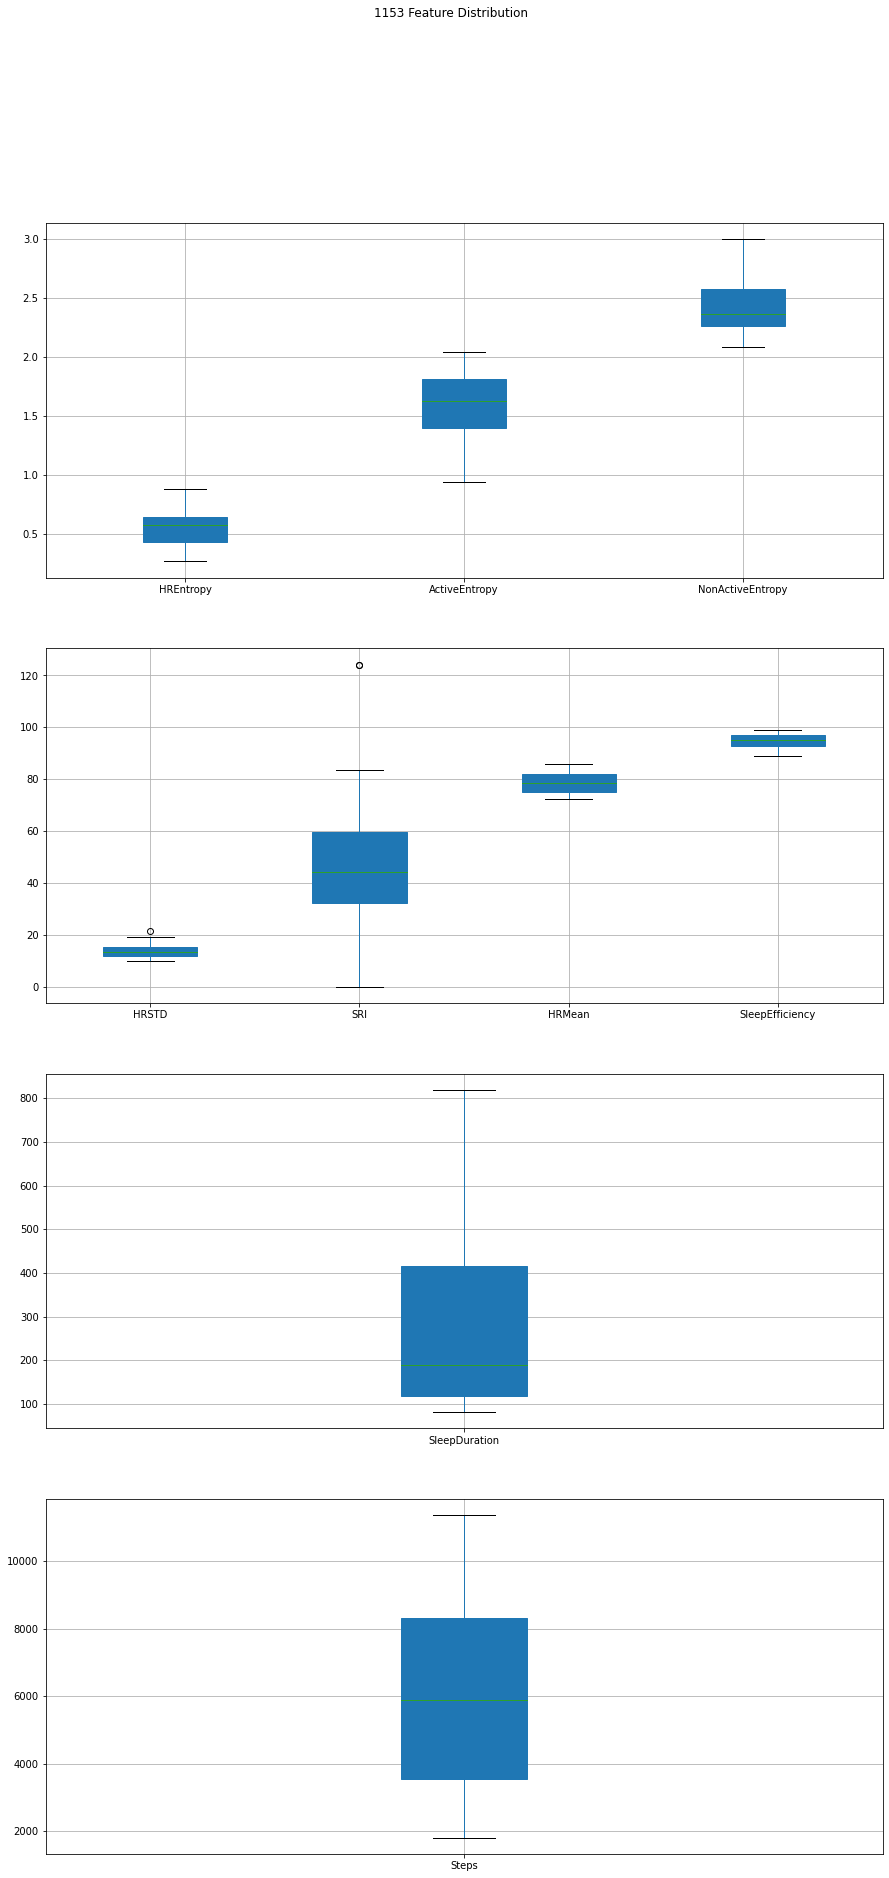

In [22]:
user = participants[0]
uf = fitbit_feat.loc[fitbit_feat['User'] == user, ['HREntropy', 'ActiveEntropy', 'NonActiveEntropy', 'HRSTD', 'SRI', 'HRMean', 'SleepEfficiency', 'SleepDuration', 'Steps']]
fig, axs = plt.subplots(4,1, figsize=(15,30))
plt.suptitle(str(user) + ' Feature Distribution')
for feat in ['HREntropy', 'ActiveEntropy', 'NonActiveEntropy', 'HRSTD', 'SRI', 'HRMean', 'SleepEfficiency', 'SleepDuration', 'Steps']:
    uf[feat] = uf[feat].astype('float64')
# Split features up by magnitude so axis is similar
uf.boxplot(column= ['HREntropy', 'ActiveEntropy', 'NonActiveEntropy'], ax = axs[0], patch_artist=True)
uf.boxplot(column= ['HRSTD', 'SRI', 'HRMean', 'SleepEfficiency'], ax = axs[1],patch_artist=True)
uf.boxplot(column= ['SleepDuration'], ax=axs[2],patch_artist=True)
uf.boxplot(column=['Steps'], ax=axs[3],patch_artist=True)
plt.show()

## Add Survey Features to table (ex. Caffeine, Alcholic Drinks, Wellbeing Scores)

In [23]:
# Function that will subtract a day from date... needed because survey dataframe shows previous days features
def convert_date(date_string):
    date0 = datetime.datetime.strptime(date_string, '%Y/%m/%d')
    subtract_day = datetime.timedelta(1)
    new_date = date0 - subtract_day
    return new_date.date()

In [24]:
# Survey features from batch 3/4 come from Han's dataframe
han_df = pd.read_csv('/Users/giabraddock/compwell/WellbeingData_20210214/WellbeingData_20210214_labels.csv', header=0)
# Subtract Day from Date
han_df.update(han_df.loc[:,'date'].apply(convert_date))

In [25]:
# Available data from Han... not all features will be used
han_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 80 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         466 non-null    int64  
 1   u_id                       466 non-null    int64  
 2   job                        466 non-null    object 
 3   date                       466 non-null    object 
 4   recorded_time              466 non-null    object 
 5   valid_eve                  466 non-null    int64  
 6   valid_morn                 466 non-null    int64  
 7   valid_shift                466 non-null    int64  
 8   valid_fitbit               466 non-null    int64  
 9   steps                      466 non-null    int64  
 10  steps_sedentary            466 non-null    int64  
 11  steps_lightly              466 non-null    int64  
 12  steps_moderately           466 non-null    int64  
 13  steps_very                 466 non-null    int64  

In [26]:
# Function to calculate nap duration in minutes, batch 3/4 fitbit did not account for naps
def nap_duration(start_date, end_date):
    if isinstance(start_date, float) or isinstance(end_date, float):
        return 0
    start = datetime.datetime.strptime(start_date[0:-4], '%H:%M:%S')
    end = datetime.datetime.strptime(end_date[0:-4], '%H:%M:%S')
    difference = end - start
    return difference.seconds//60

**Features to extract are: 'NumberofNaps', 'NapDuration', 'CupsofCaffeine', 'AlcoholicDrinks', 'WakeMethod(0-2)', 'TimeToFallAsleep(0-5)', 'HoursWorked', 'OverTime(Mins)', 'NoSleep', 'ShiftType(1-3)', 'AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening'**

In [27]:
# Going to extract 20 features from Han's DF
survey_feat = pd.DataFrame([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]], columns = ['User', 'Date', 'CupsofCaffeine', 'AlcoholicDrinks', 'WakeMethod(0-2)', 'TimeToFallAsleep(0-5)', 'HoursWorked', 'OverTime(Mins)', 'NoSleep', 'ShiftType(1-3)', 'AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening'])
nap_feat = pd.DataFrame([[0,0,0,0]], columns = ['User', 'Date','NumberofNaps', 'NapDuration'])
for idx, row in han_df.iterrows():
    # Get all features
    date = row['date'].strftime('%Y-%m-%d')
    user = str(row['u_id'])
    number_of_naps = row['naps']
    nap1_duration = nap_duration(row['nap1_start'], row['nap1_end'])
    nap2_duration = nap_duration(row['nap2_start'], row['nap2_end'])
    nap3_duration = nap_duration(row['nap3_start'], row['nap3_end'])
    caf = row['caffeine_cups']
    alc = row['alcohol']
    wake_type = row['awake_type']
    fall_asleep = row['fallsleep_time']
    work_time = row['shift_hours']
    alertm = row['alterness_morning']
    alerte = row['alertness_evening']
    happym = row['happiness_morning']
    happye = row['happiness_evening']
    energym = row['energy_morning']
    energye = row['energy_evening']
    healthm = row['health_morning']
    healthe = row['health_evening']
    relaxm = row['relax_morning']
    relaxe = row['relax_evening']
    # Overwork time is any shift that lasts longer than 8 hours, feature table shows overtime in minutes
    if work_time > 8:
        overwork = (work_time - 8)*60
    else:
        overwork = 0
    nosleep = row['no_sleep']
    shift = row['shift']
    # Shift keys include 9 and 31?
    if shift == 9.0 or shift == 31.0:
        shift = 0
    # Separate nap data frame so we don't create extra nap columns when merging data frames
    df1 = pd.DataFrame([[user, date, number_of_naps, (nap1_duration + nap2_duration + nap3_duration)]], columns = ['User', 'Date', 'NumberofNaps', 'NapDuration'])
    df0 = pd.DataFrame([[user, date, caf, alc, wake_type, fall_asleep, work_time, overwork, nosleep, shift, alertm, alerte, happym, happye, energym, energye, healthm, healthe, relaxm, relaxe]], columns = ['User', 'Date', 'CupsofCaffeine', 'AlcoholicDrinks', 'WakeMethod(0-2)', 'TimeToFallAsleep(0-5)', 'HoursWorked', 'OverTime(Mins)', 'NoSleep', 'ShiftType(1-3)', 'AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening'])
    survey_feat = pd.concat([survey_feat, df0], ignore_index=True)
    nap_feat = pd.concat([nap_feat, df1], ignore_index=True)
survey_feat.drop([0], inplace=True)
nap_feat.drop([0], inplace=True)
survey_feat.head()

,User,Date,CupsofCaffeine,AlcoholicDrinks,WakeMethod(0-2),TimeToFallAsleep(0-5),HoursWorked,OverTime(Mins),NoSleep,ShiftType(1-3),AlertnessMorning,AlertnessEvening,HappinessMorning,HappinessEvening,EnergyMorning,EnergyEvening,HealthMorning,HealthEvening,RelaxMorning,RelaxEvening
1,1001,2020-10-23,3,0,2,0,8,0,1,3.0,36,0,21,0,31,0,32,0,64,0
2,1001,2020-10-24,0,0,0,0,8,0,1,1.0,0,70,0,70,0,77,0,73,0,74
3,1001,2020-10-25,3,0,2,0,8,0,1,1.0,20,38,30,34,29,39,17,36,30,20
4,1001,2020-10-26,0,0,0,0,8,0,1,1.0,0,30,0,32,0,13,0,66,0,66
5,1001,2020-10-27,3,0,2,0,0,0,1,NaN,32,27,31,71,31,73,67,35,62,70


In [28]:
# Add survey features to fitbit table
feature_table = survey_feat.merge(fitbit_feat, how = 'outer', on=['User', 'Date'])

In [29]:
# Add nap data
for i, r in nap_feat.iterrows():
    feature_table.loc[(feature_table['User'] == r['User']) & (feature_table['Date'] == r['Date']), ['NumberofNaps', 'NapDuration']] = [r['NumberofNaps'], r['NapDuration']]

In [30]:
# Need to make sure we didn't add survey data that extends beyond the study's 5-week period
dropi = []
# If User, Date combo is not in fitbit table, drop the row
for idx, r in feature_table.iterrows():
    u = r['User']
    date = r['Date']
    if u not in fitbit_feat.loc[:,'User'].values:
        dropi.append(idx)
feature_table.drop(dropi, inplace=True)


**Add batch 1 survey data**

In [31]:
batch1_survey = pd.read_csv('/Users/giabraddock/compwell/merged_data2.csv', header=0)
batch1_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 70 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   userid                     298 non-null    object 
 1   date                       298 non-null    object 
 2   job                        298 non-null    object 
 3   alterness_morning          298 non-null    int64  
 4   happiness_morning          298 non-null    int64  
 5   energy_morning             298 non-null    int64  
 6   health_morning             298 non-null    int64  
 7   relax_morning              298 non-null    int64  
 8   alertness_evening          296 non-null    float64
 9   happiness_evening          298 non-null    int64  
 10  energy_evening             297 non-null    float64
 11  health_evening             298 non-null    int64  
 12  relax_evening              296 non-null    float64
 13  noSleep                    288 non-null    float64

In [32]:
# Going to extract 18 features from merged csv 2
survey_feat2 = pd.DataFrame([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]], columns = ['User', 'Date', 'CupsofCaffeine', 'AlcoholicDrinks', 'WakeMethod(0-2)', 'TimeToFallAsleep(0-5)', 'HoursWorked', 'OverTime(Mins)', 'NoSleep', 'ShiftType(1-3)', 'AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening'])
for idx, row in batch1_survey.iterrows():
    # Get all features
    date = '2' + row['date'][1:]
    user = str(row['userid'])
    # Caffeine Cups
    if row['numCaff_3.0']:
        caf = 3
    elif row['numCaff_2.0']:
        caf = 2
    elif row['numCaff_1.0']:
        caf = 1
    elif row['numCaff_0.0']:
        caf = 0
    else:
        caf = None
    alc = row['AlcoDrugMedi']
    # Wake Method
    if row['awakeType_0.0']:
        wake_type = 0
    elif row['awakeType_1.0']:
        wake_type = 1
    elif row['awakeType_2.0']:
        wake_type = 2
    else:
        wake_type = None
    # Interval of time to fall asleep
    if row['timeFallSleep_0.0']:
        fall_asleep = 0
    elif row['timeFallSleep_1.0']:
        fall_asleep = 1
    elif row['timeFallSleep_2.0']:
        fall_asleep = 2
    elif row['timeFallSleep_3.0']:
        fall_asleep = 3
    elif row['timeFallSleep_4.0']:
        fall_asleep = 4
    elif row['timeFallSleep_5.0']:
        fall_asleep = 5
    else:
        fall_asleep = None
    # Shift type
    if row['shift1']:
        shift = 1
    elif row['shift2']:
        shift = 2
    elif row['shift3']:
        shift = 3
    else:
        shift = None
    work_time = row['totalhour']
    alertm = row['alterness_morning']
    alerte = row['alertness_evening']
    happym = row['happiness_morning']
    happye = row['happiness_evening']
    energym = row['energy_morning']
    energye = row['energy_evening']
    healthm = row['health_morning']
    healthe = row['health_evening']
    relaxm = row['relax_morning']
    relaxe = row['relax_evening']
    overwork = row['overworkTime']
    nosleep = row['noSleep']
    # Add each row of features to table
    df0 = pd.DataFrame([[user, date, caf, alc, wake_type, fall_asleep, work_time, overwork, nosleep, shift, alertm, alerte, happym, happye, energym, energye, healthm, healthe, relaxm, relaxe]], columns = ['User', 'Date', 'CupsofCaffeine', 'AlcoholicDrinks', 'WakeMethod(0-2)', 'TimeToFallAsleep(0-5)', 'HoursWorked', 'OverTime(Mins)', 'NoSleep', 'ShiftType(1-3)', 'AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening'])
    survey_feat2 = pd.concat([survey_feat2, df0], ignore_index=True)
# Drop row of zeros added in initialization 
survey_feat2.drop([0], inplace=True)
survey_feat2.head()

,User,Date,CupsofCaffeine,AlcoholicDrinks,WakeMethod(0-2),TimeToFallAsleep(0-5),HoursWorked,OverTime(Mins),NoSleep,ShiftType(1-3),AlertnessMorning,AlertnessEvening,HappinessMorning,HappinessEvening,EnergyMorning,EnergyEvening,HealthMorning,HealthEvening,RelaxMorning,RelaxEvening
1,fitbit001,2019-05-23,2,0.0,1,1,8,30.0,1.0,3,50,54.0,53,56,54,53.0,53,53,56,52.0
2,fitbit001,2019-05-26,1,0.0,0,0,8,135.0,1.0,2,100,NaN,100,63,100,66.0,100,66,100,69.0
3,fitbit001,2019-05-28,1,0.0,0,0,0,0.0,1.0,None,78,61.0,69,69,69,63.0,71,64,70,82.0
4,fitbit001,2019-05-30,2,0.0,0,0,8,0.0,1.0,2,100,88.0,100,83,99,83.0,100,86,98,80.0
5,fitbit001,2019-06-01,1,0.0,0,1,0,0.0,1.0,None,76,69.0,77,70,76,73.0,79,70,82,89.0


In [33]:
# Add survey features to fitbit table
for i, r in survey_feat2.iterrows():
    feature_table.loc[(feature_table['User'] == r['User']) & (feature_table['Date'] == r['Date']), ['CupsofCaffeine', 'AlcoholicDrinks', 'WakeMethod(0-2)', 'TimeToFallAsleep(0-5)', 'HoursWorked', 'OverTime(Mins)', 'NoSleep', 'ShiftType(1-3)', 'AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening']] = [r['CupsofCaffeine'], r['AlcoholicDrinks'], r['WakeMethod(0-2)'], r['TimeToFallAsleep(0-5)'], r['HoursWorked'], r['OverTime(Mins)'], r['NoSleep'], r['ShiftType(1-3)'], r['AlertnessMorning'], r['AlertnessEvening'], r['HappinessMorning'], r['HappinessEvening'], r['EnergyMorning'], r['EnergyEvening'], r['HealthMorning'], r['HealthEvening'], r['RelaxMorning'], r['RelaxEvening']]

In [34]:
feature_table.drop_duplicates(inplace=True)

In [35]:
feature_table.User.value_counts()

1001         81
1153         44
1103         41
1105         40
1157         40
1108         38
1115         38
1158         38
1102         38
1151         38
1154         37
fitbit004    36
fitbit003    36
1156         36
1155         36
fitbit006    35
1150         35
fitbit009    34
1114         30
fitbit002    29
fitbit011    29
fitbit010    28
fitbit005    28
fitbit001    27
1159          7
fitbit014     2
Name: User, dtype: int64

In [36]:
# Need to make sure we didn't add survey data that extends beyond the study's 5-week period
dropi = []
# full_fitbit_data df stored all user, date pairs that we have fitbit data for
for i, r in feature_table.iterrows():
    if r['User'] not in list(full_fitbit_data.User.values):
        dropi.append(i)
    else:
        ufeat = full_fitbit_data.loc[full_fitbit_data['User'] == r['User'], ['Date']]
        if r['Date'] not in list(ufeat.Date.values):
            dropi.append(i)
            
feature_table.drop(dropi, inplace=True)

In [37]:
feature_table.User.value_counts()

fitbit004    36
1108         36
fitbit003    36
1156         35
1158         35
1157         35
1105         35
fitbit006    35
1155         34
fitbit009    34
1151         34
1150         33
1102         33
1115         32
1103         31
1154         31
fitbit002    29
fitbit011    29
fitbit010    28
1153         28
fitbit005    28
fitbit001    27
1114         24
1001         16
1159          7
fitbit014     2
Name: User, dtype: int64

## Summary Statistics for Survey Features

In [38]:
survey_mean = feature_table.loc[:,['NumberofNaps','NapDuration', 'CupsofCaffeine', 'AlcoholicDrinks', 'HoursWorked', 'OverTime(Mins)', 'AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening']].mean()
survey_std = feature_table.loc[:,['NumberofNaps','NapDuration','CupsofCaffeine', 'AlcoholicDrinks', 'HoursWorked', 'OverTime(Mins)', 'AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening']].std()
survey_summary = pd.concat([survey_mean, survey_std], axis = 1)
survey_summary.columns = ['Mean', 'Standard Deviation']
survey_summary

,Mean,Standard Deviation
NumberofNaps,0.347518,0.568390
NapDuration,78.819149,208.374200
CupsofCaffeine,0.824219,1.020513
AlcoholicDrinks,0.183953,0.482454
HoursWorked,4.328125,4.021682
OverTime(Mins),38.447266,160.725730
AlertnessMorning,42.445312,27.237036
AlertnessEvening,40.421569,26.379964
HappinessMorning,54.480469,25.411055
HappinessEvening,54.585938,26.443834


**Summary Statistics for Categorical Variables**

In [39]:
# Wake Method (Natural, Alarm, Other)
vals = survey_feat.loc[:,['WakeMethod(0-2)']].value_counts()
total = survey_feat.loc[:,['WakeMethod(0-2)']].count().values[0]
# Only need the first two digits
wmt_string0 = str(vals.values[0]/total)[2:4] +'%' 
wmt_string1 = str(vals.values[1]/total)[2:4] +'%' 
wmt_string2 = str(vals.values[2]/total)[2:4] +'%'
idx = [str(x)[1:2] for x in list(vals.index)]
wmt = pd.DataFrame([wmt_string0, wmt_string1, wmt_string2], columns = ['WakeMethod(0-2)'])
wmt.set_index(pd.Index(list(vals.index)), inplace=True)
wmt

,WakeMethod(0-2)
0,53%
2,24%
1,22%


In [40]:
# Shift Type/Number
vals = survey_feat.loc[:,['ShiftType(1-3)']].value_counts()
total = survey_feat.loc[:,['ShiftType(1-3)']].count().values[0]
stt_string0 = str(vals.values[0]/total)[2:4] +'%' 
stt_string1 = str(vals.values[1]/total)[2:4] +'%' 
stt_string2 = str(vals.values[2]/total)[2:4] +'%'
stt_string3 = str(vals.values[3]/total)[2:4] +'%'
idx = [str(x)[1:2] for x in list(vals.index)]
stt = pd.DataFrame([stt_string0, stt_string1, stt_string2, stt_string3], columns = ['ShiftType(1-3)'])
stt.set_index(pd.Index(list(vals.index)), inplace=True)
stt

,ShiftType(1-3)
1.0,36%
2.0,27%
3.0,24%
0.0,12%


In [41]:
# Time to Fall Asleep
vals = survey_feat.loc[:,['TimeToFallAsleep(0-5)']].value_counts()
total = survey_feat.loc[:,['TimeToFallAsleep(0-5)']].count().values[0]
tts0 = str(vals.values[0]/total)[2:4] +'%' 
tts1 = str(vals.values[1]/total)[2:4] +'%' 
tts2 = str(vals.values[2]/total)[3:4] +'%'
tts3 = str(vals.values[3]/total)[3:4] +'%'
tts4 = str(vals.values[4]/total)[3:4] +'%'
tts = pd.DataFrame([tts0, tts1, tts2, tts3, tts4], columns = ['TimeToFallAsleep(0-5)'])
tts.set_index(pd.Index(list(vals.index)), inplace=True)
tts

,TimeToFallAsleep(0-5)
0,62%
1,26%
2,6%
3,2%
4,1%


**Graphs of Summary Statistics**

<ipython-input-42-1999b60f206e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uf['NapDuration'] = uf['NapDuration'].astype('float64')


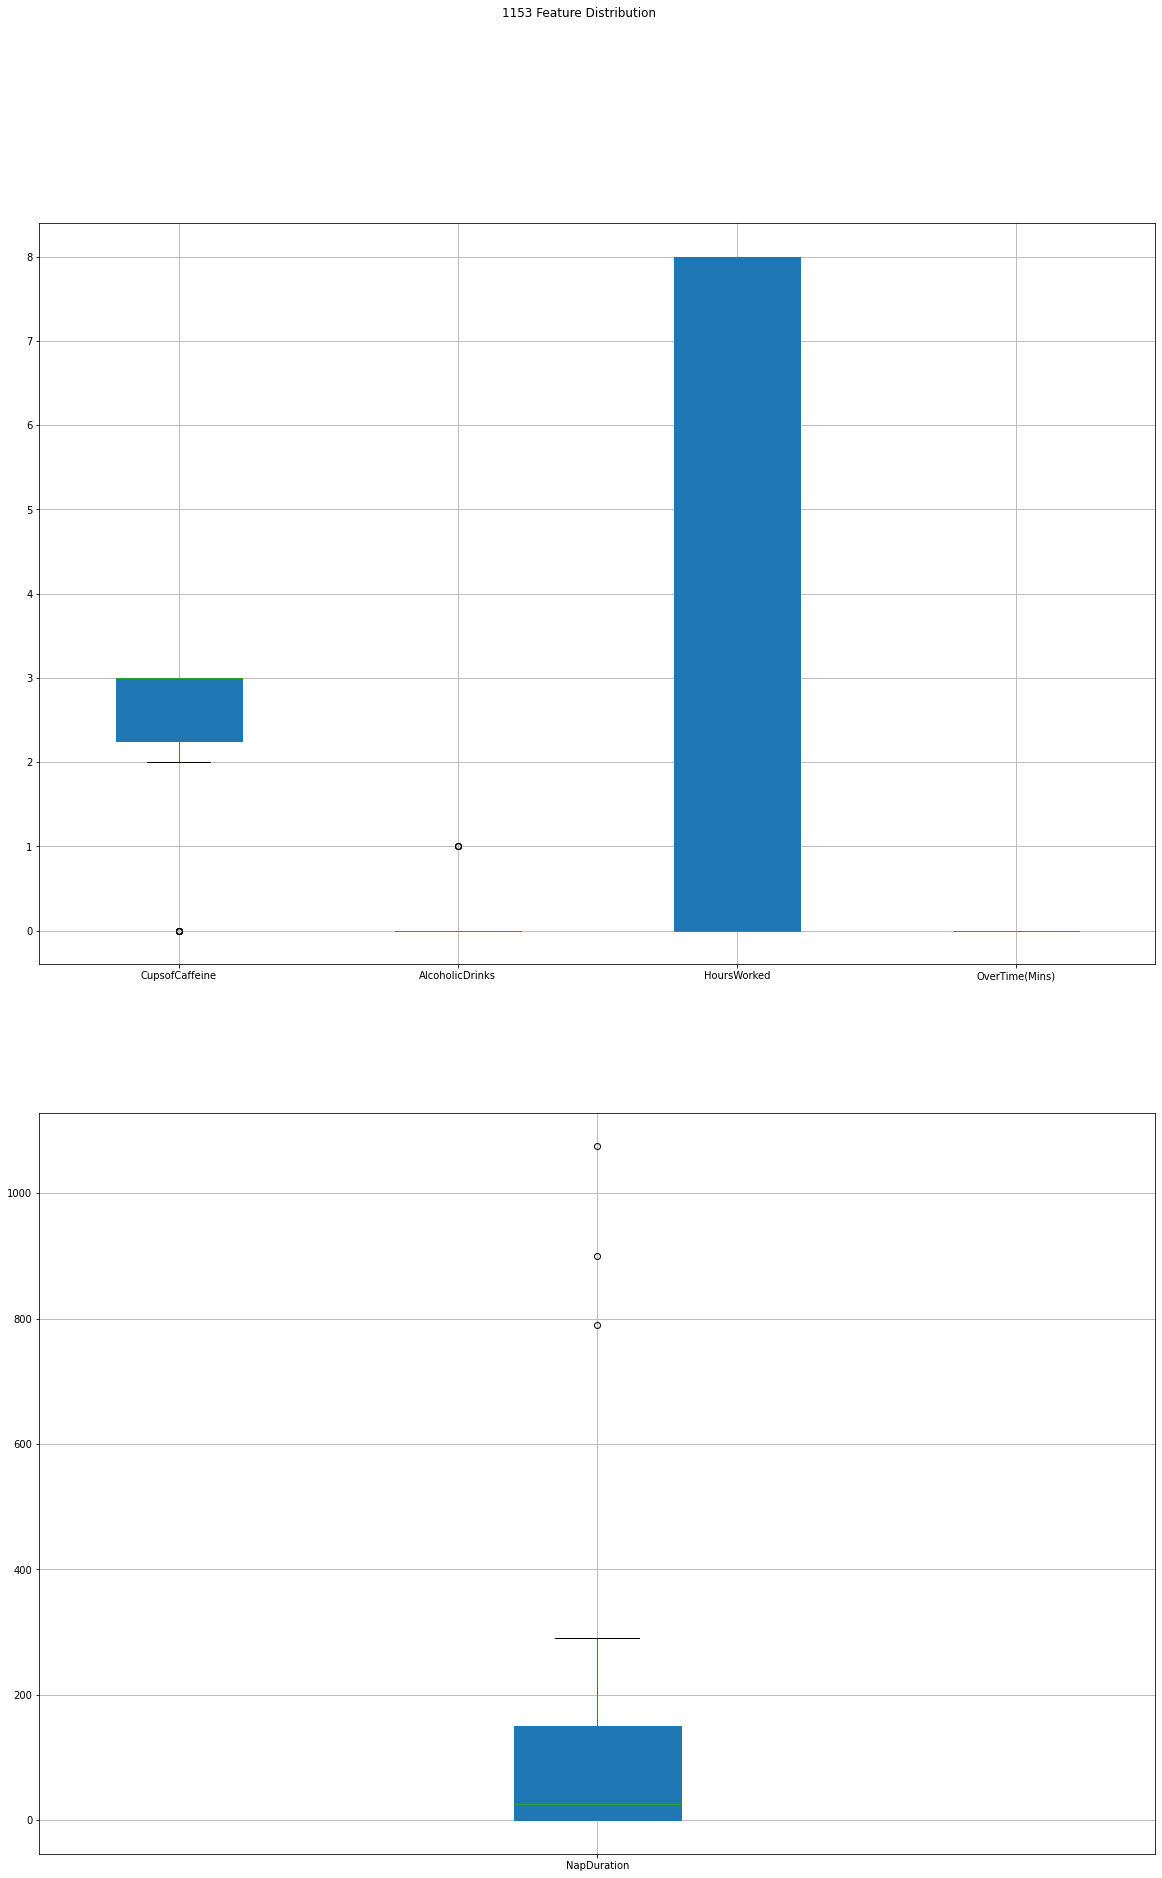

In [42]:
# Can plot the distribution for each participant
user = participants[0]
uf = feature_table.loc[feature_table['User'] == user]
fig, axs = plt.subplots(2,1, figsize=(20,30))
plt.suptitle(str(user) + ' Feature Distribution')
# Different plots for different features based on their magnitude
uf.boxplot(column= ['CupsofCaffeine', 'AlcoholicDrinks', 'HoursWorked', 'OverTime(Mins)'], ax = axs[0], patch_artist=True)
uf['NapDuration'] = uf['NapDuration'].astype('float64')
uf.boxplot(column= ['NapDuration'], ax=axs[1], patch_artist=True)
plt.show()

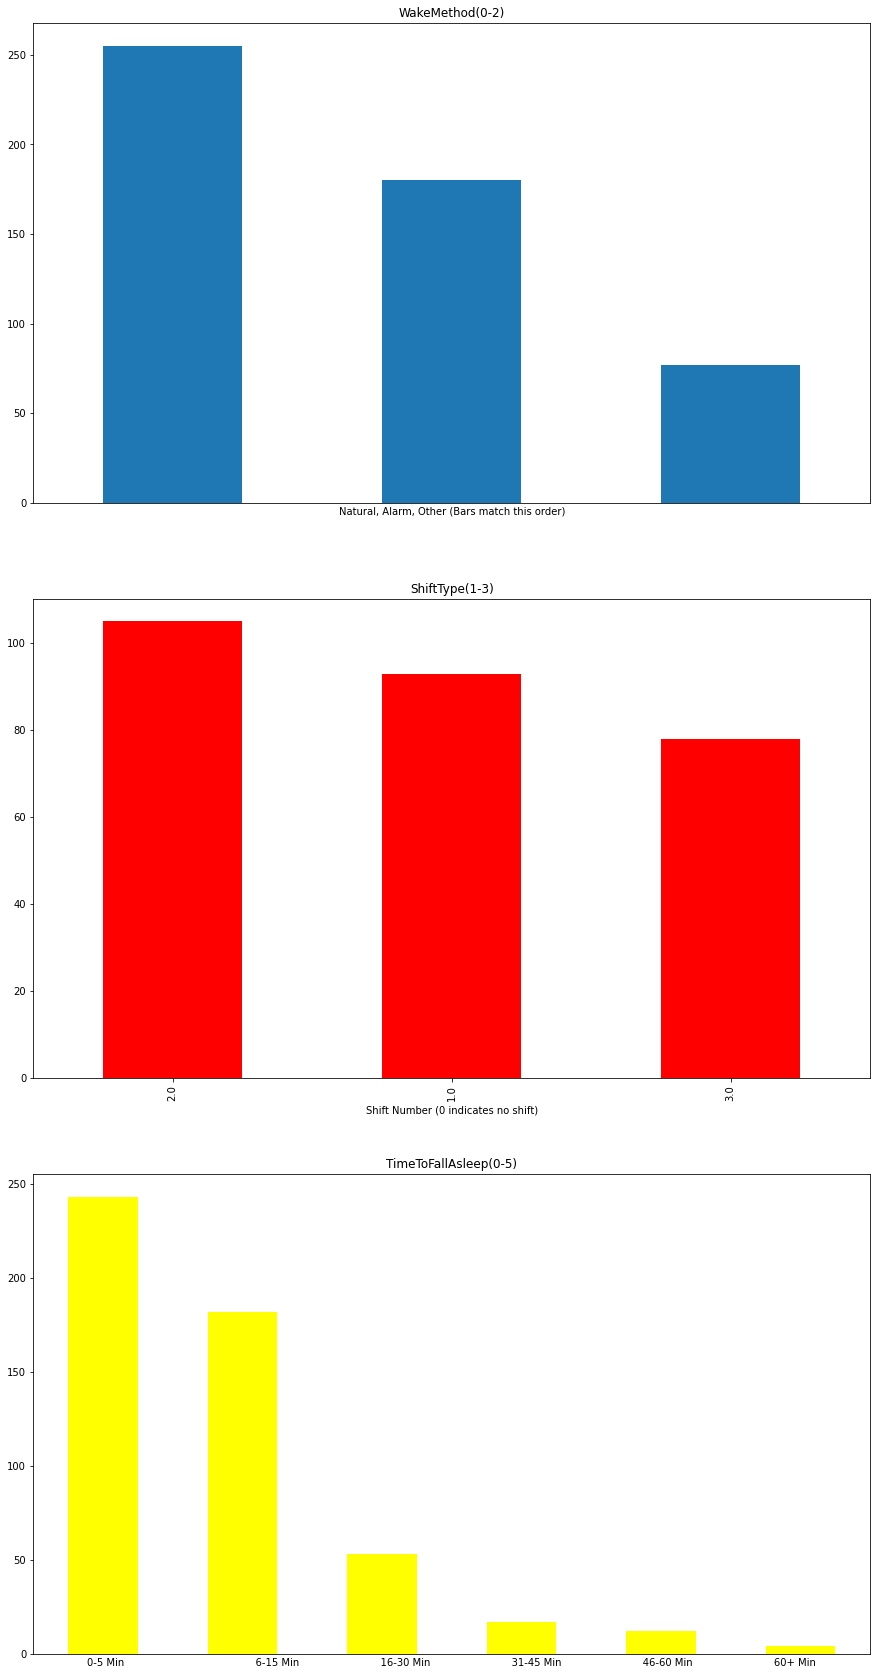

In [43]:
# Plot Categorical variables
fig, axs = plt.subplots(3,1, figsize=(15,30))
feature_table['WakeMethod(0-2)'].value_counts().plot(kind='bar', ax=axs[0], title='WakeMethod(0-2)', xticks=[], xlabel = 'Natural, Alarm, Other (Bars match this order)')
feature_table['ShiftType(1-3)'].value_counts().plot(kind='bar', color='red', ax=axs[1], title='ShiftType(1-3)', xlabel = 'Shift Number (0 indicates no shift)')
# 'Shift 1', 'Shift 2', 'Shift 3', 'Unspecified'
feature_table['TimeToFallAsleep(0-5)'].value_counts().plot(kind='bar', color='yellow', ax=axs[2], title='TimeToFallAsleep(0-5)', xticks=[], xlabel= '0-5 Min                                          6-15 Min                          16-30 Min                          31-45 Min                          46-60 Min                          60+ Min')
plt.show()

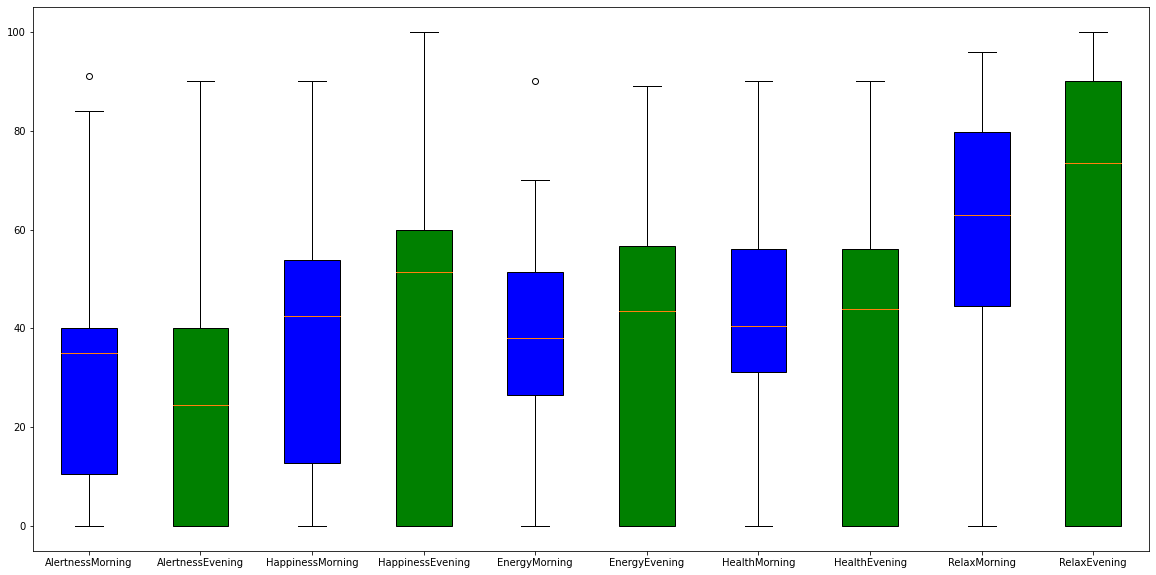

In [44]:
# For Wellbeing features set distribution boxplots to different colors to distinguish between morning and evening
fig = plt.figure(figsize= (20,10))
feat_dict = {}
colors = ['blue', 'green', 'blue', 'green','blue', 'green', 'blue', 'green', 'blue', 'green']
for f in ['AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening']:
    feat_dict[f] = [x for x in list(uf.loc[:, f].values) if str(x) != 'nan']
box = plt.boxplot(x=feat_dict.values(), labels=feat_dict.keys(), patch_artist=True)
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

## Hot Encoding

In [45]:
dummy_nap = pd.get_dummies(feature_table['NumberofNaps'])
dummy_caf = pd.get_dummies(feature_table['CupsofCaffeine'])
dummy_alc = pd.get_dummies(feature_table['AlcoholicDrinks'])
dummy_wm = pd.get_dummies(feature_table['WakeMethod(0-2)'])
dummy_tts = pd.get_dummies(feature_table['TimeToFallAsleep(0-5)'])
dummy_shift = pd.get_dummies(feature_table['ShiftType(1-3)'])
dummy_restless = pd.get_dummies(feature_table['SleepRestlessness'])

## Look at High vs. Low Risk Burnout Participants

In [46]:
# Burnout scale info for batch 3/4, no batch 1 jbs information
jbs = pd.read_csv('/Users/giabraddock/compwell/CompWell_REU2021/jbs_table.csv')

In [47]:
# Want to see how many participants are above the JBS-D cutoff score 
# Made a set because a participant may fall above on the pre and post survey
highrisk_d = set()
for i, row in jbs.loc[:, ['u_id', 'score_d']].iterrows():
    if row['score_d'] >= 2.06:
        highrisk_d.add(str(row['u_id'])[0:4])
# Want to see how many participants are above the JBS-E cutoff score 
highrisk_e = set()
for i, row in jbs.loc[:, ['u_id', 'score_e']].iterrows():
    if row['score_e'] >= 3.2:
        highrisk_e.add(str(row['u_id'])[0:4])
# Want to see how many partipants are above the JBS-PA cutoff score
highrisk_pa = set()
for i, row in jbs.loc[:, ['u_id', 'score_pa']].iterrows():
    if row['score_pa'] >= 3.51:
        highrisk_pa.add(str(row['u_id'])[0:4])

In [48]:
# All 13 users with jbs info
print(jbs.u_id.unique(), len(jbs.u_id.unique()))

[1153 1102 1159 1103 1151 1108 1158 1155 1115 1154 1150 1157 1156] 13


In [49]:
# 8 highrisk JBS-D
print(highrisk_d, len(highrisk_d))
# 9 highrisk JBS-E
print(highrisk_e, len(highrisk_e))
# 3 highrisk JBS-PA
print(highrisk_pa, len(highrisk_pa))

{'1153', '1108', '1115', '1158', '1102', '1151', '1157', '1154'} 8
{'1153', '1108', '1115', '1158', '1102', '1103', '1157', '1154', '1150'} 9
{'1151', '1103', '1155'} 3


In [50]:
# only leave scores in jbs table
jbs.drop(['Unnamed: 0', 'id', 'recorded_time', 'start_time',
       'end_time', 'duration', 'ip_address', 'finished', 'Q1', 'Q2', 'Q3',
       'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14',
       'Q15', 'Q16', 'Q17'], axis = 1, inplace=True)

In [51]:
# Change columns to keep previous format
jbs.rename(columns={'u_id':'User', 'date': 'Date'}, inplace=True)

In [52]:
# Add JBS scores to feature_table
# Start by making a dictionary storing all scores, store max of pre and post score
score_dict = defaultdict(lambda: defaultdict(int))
jbs['User'] = jbs['User'].astype('str')
for i, r in jbs.iterrows():
    score_dict[r['User']] = [max(jbs.loc[jbs['User'] == r['User'], 'score_e'].values), max(jbs.loc[jbs['User'] == r['User'], 'score_d'].values), max(jbs.loc[jbs['User'] == r['User'], 'score_pa'].values)]
# # Copy feature table
ft_risk = feature_table.copy()
# Beacuse many users don't have JBS data, set all scores to NaN
ft_risk['EScore'] = np.nan
ft_risk['DScore'] = np.nan
ft_risk['PAScore'] = np.nan
# Add JBS scores where relevant
for i, r in ft_risk.iterrows():
    user = r['User']
    if user in score_dict.keys():
        [e, d, pa] = score_dict[user]
        ft_risk.loc[i,'EScore'] = e
        ft_risk.loc[i,'DScore'] = d
        ft_risk.loc[i,'PAScore'] = pa

In [53]:
# Sort table by increasing E score values, makes a gradient from least to most at risk of burnout
# Note that individuals without data will be at the end of the frame
ft_risk.sort_values(by='EScore', inplace=True)
# 1159 is the least at risk based on E score and 1108 is the most at risk
print(ft_risk.User.unique())

['1159' '1156' '1155' '1151' '1103' '1153' '1158' '1150' '1102' '1115'
 '1157' '1154' '1108' '1001' '1105' '1114' 'fitbit001' 'fitbit002'
 'fitbit003' 'fitbit004' 'fitbit005' 'fitbit006' 'fitbit009' 'fitbit010'
 'fitbit011' 'fitbit014']


In [54]:
# Get feature table for entries with PA scores above the cutoff
hfpa = ft_risk.loc[ft_risk['PAScore'] >= 3.51]
# Get feature table for entries with E scores above the cutoff
hfe = ft_risk.loc[ft_risk['EScore'] >= 3.27]
# Get feature table for entries with D scores above the cutoff
hfd = ft_risk.loc[ft_risk['DScore'] >= 2.06]
# Combine tables and drop duplicates
highrisk = pd.concat([hfpa, hfe, hfd], join='inner')
highrisk.drop_duplicates(inplace=True, ignore_index=True)
highrisk.User.unique()

array(['1155', '1151', '1103', '1150', '1102', '1115', '1157', '1154',
       '1108', '1153', '1158'], dtype=object)

In [55]:
# Get lowrisk individuals, only 2 not at risk for any burnout: 1159 and 1156
lowrisk = ft_risk.loc[(ft_risk['User'].isin(highrisk['User'])==False) & (ft_risk['User'].isin(jbs.User))]
lowrisk.User.unique()

array(['1159', '1156'], dtype=object)

**Plot features for highrisk vs. lowrisk participants**

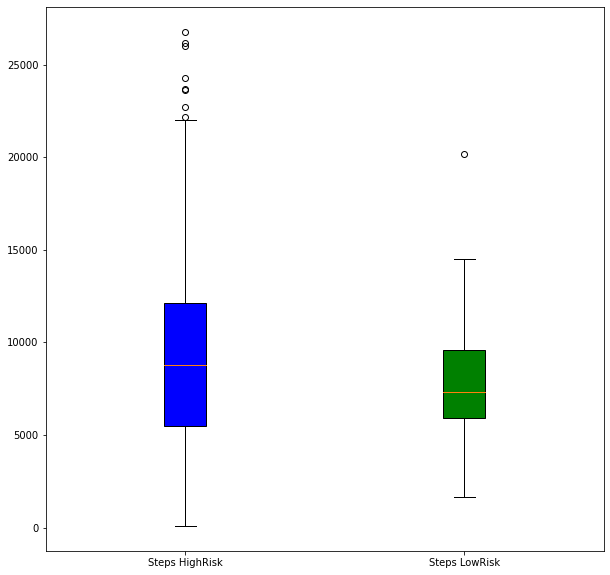

In [56]:
# Start with features with the highest magnitude 
fig = plt.figure(figsize= (10,10))
feat = 'Steps'
hr = [x for x in list(highrisk.loc[:, feat].values) if str(x) != 'nan']
lr = [x for x in list(lowrisk.loc[:, feat].values) if str(x) != 'nan']
feat_dict = {'Steps HighRisk' :hr, 'Steps LowRisk' :lr}
box = plt.boxplot(x=feat_dict.values(), labels=feat_dict.keys(), patch_artist=True)

colors = ['blue', 'green', 'blue', 'green','blue', 'green', 'blue', 'green']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    
plt.show()

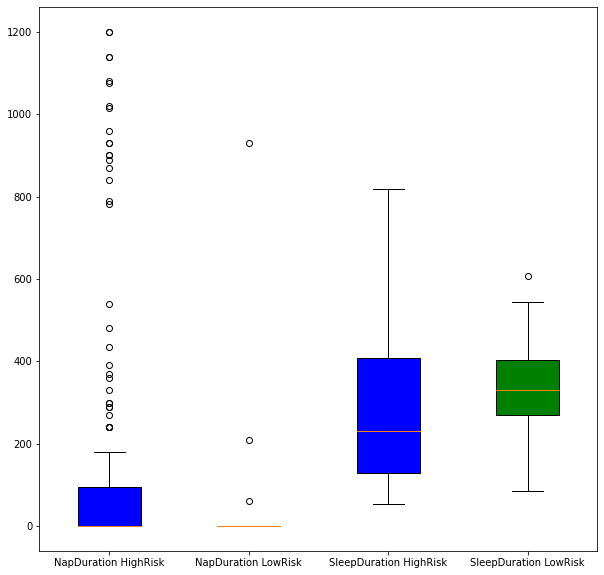

In [57]:
# Features with smaller magnitude
feat = ['NapDuration', 'SleepDuration']
fig = plt.figure(figsize= (10,10))
feat_dict = {}
for f in feat:
    feat_dict[f + ' ' + 'HighRisk'] = [x for x in list(highrisk.loc[:, f].values) if str(x) != 'nan']
    feat_dict[f + ' ' + 'LowRisk'] = [x for x in list(lowrisk.loc[:, f].values) if str(x) != 'nan']
box = plt.boxplot(x=feat_dict.values(), labels=feat_dict.keys(), patch_artist=True)

colors = ['blue', 'green', 'blue', 'green']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    
plt.show()

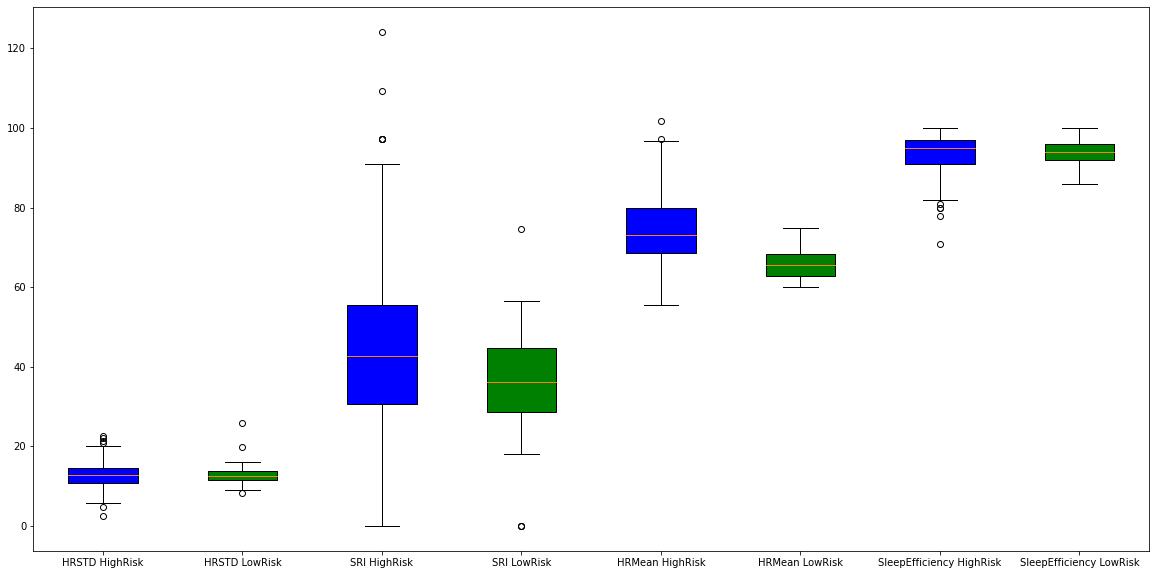

In [58]:
# Smaller magnitude
feat = ['HRSTD', 'SRI', 'HRMean', 'SleepEfficiency']
fig = plt.figure(figsize= (20,10))
feat_dict = {}
for f in feat:
    feat_dict[f + ' ' + 'HighRisk'] = [x for x in list(highrisk.loc[:, f].values) if str(x) != 'nan']
    feat_dict[f + ' ' + 'LowRisk'] = [x for x in list(lowrisk.loc[:, f].values) if str(x) != 'nan']
box = plt.boxplot(x=feat_dict.values(), labels=feat_dict.keys(), patch_artist=True)

colors = ['blue', 'green', 'blue', 'green','blue', 'green', 'blue', 'green']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.show()

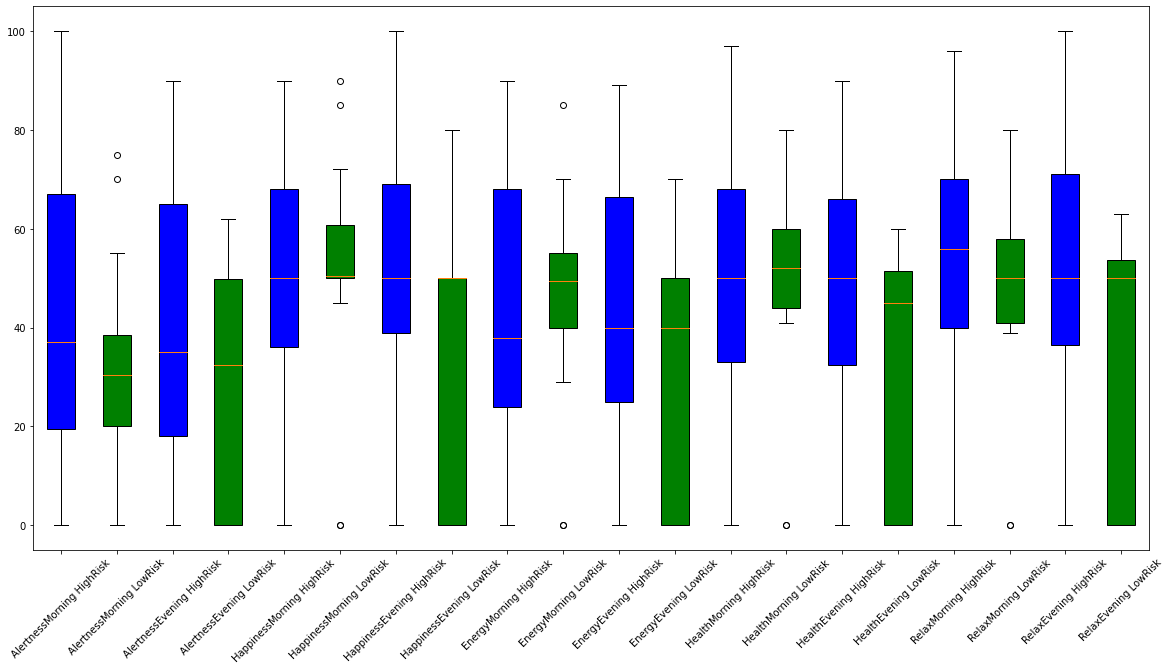

In [59]:
feat = ['AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening']
fig = plt.figure(figsize= (20,10))
feat_dict = {}
for f in feat:
    feat_dict[f + ' ' + 'HighRisk'] = [x for x in list(highrisk.loc[:, f].values) if str(x) != 'nan']
    feat_dict[f + ' ' + 'LowRisk'] = [x for x in list(lowrisk.loc[:, f].values) if str(x) != 'nan']
box = plt.boxplot(x=feat_dict.values(), labels=feat_dict.keys(), patch_artist=True)

colors = ['blue', 'green', 'blue', 'green','blue', 'green', 'blue', 'green', 'blue', 'green']* 2

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.xticks(rotation = 45)

plt.show()

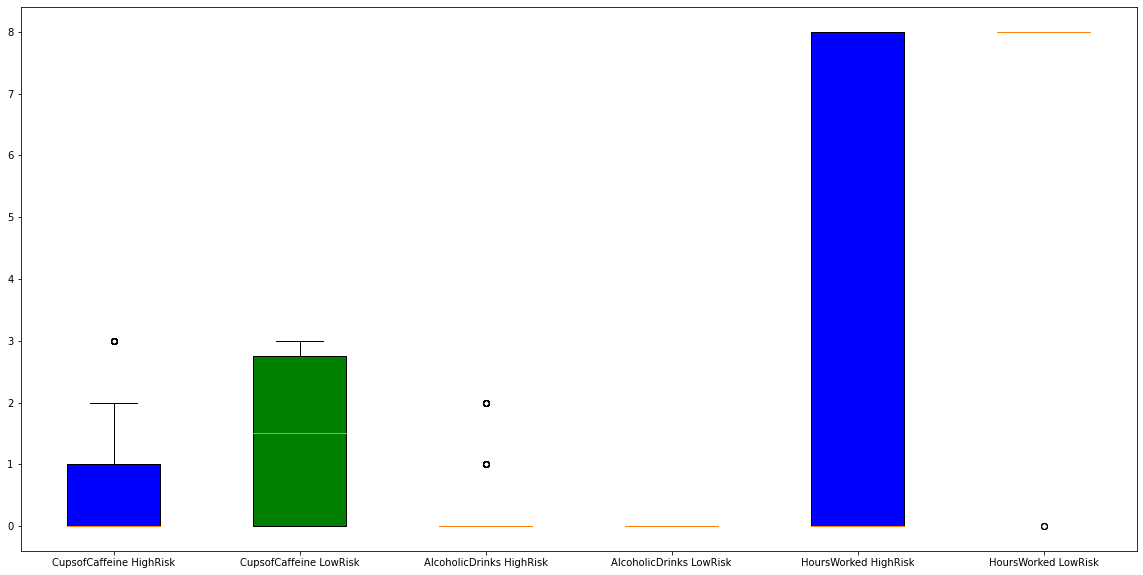

In [60]:
feat = ['CupsofCaffeine', 'AlcoholicDrinks', 'HoursWorked'] 
fig = plt.figure(figsize= (20,10))
feat_dict = {}
for f in feat:
    feat_dict[f + ' ' + 'HighRisk'] = [x for x in list(highrisk.loc[:, f].values) if str(x) != 'nan']
    feat_dict[f + ' ' + 'LowRisk'] = [x for x in list(lowrisk.loc[:, f].values) if str(x) != 'nan']
box = plt.boxplot(x=feat_dict.values(), labels=feat_dict.keys(), patch_artist=True)

colors = ['blue', 'green', 'blue', 'green','blue', 'green', 'blue', 'green']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

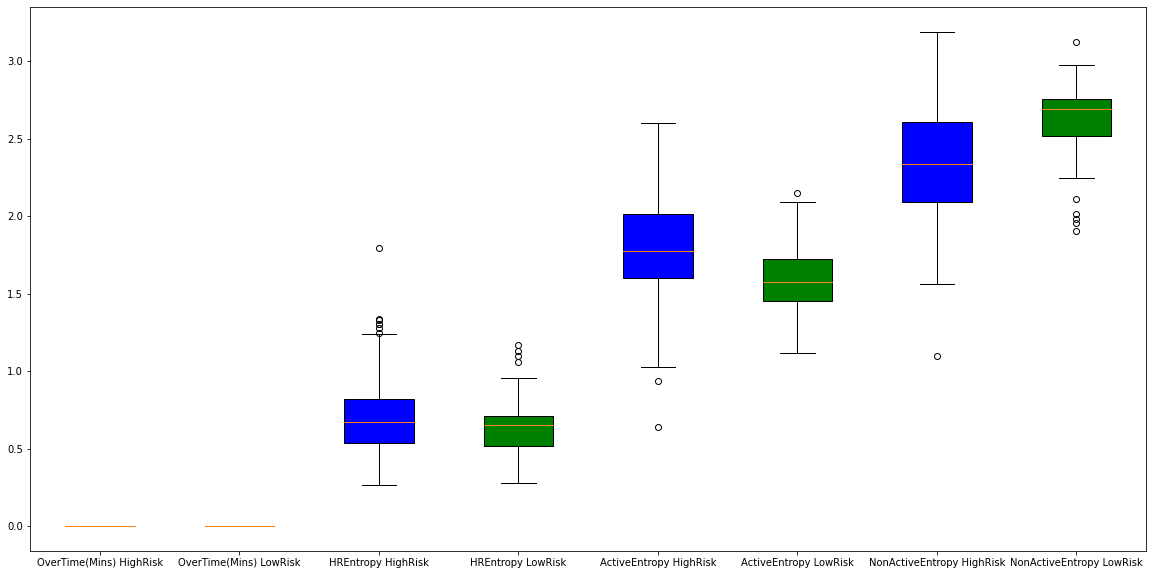

In [61]:
feat = ['OverTime(Mins)', 'HREntropy', 'ActiveEntropy', 'NonActiveEntropy']
fig = plt.figure(figsize= (20,10))
feat_dict = {}
for f in feat:
    feat_dict[f + ' ' + 'HighRisk'] = [x for x in list(highrisk.loc[:, f].values) if str(x) != 'nan']
    feat_dict[f + ' ' + 'LowRisk'] = [x for x in list(lowrisk.loc[:, f].values) if str(x) != 'nan']
box = plt.boxplot(x=feat_dict.values(), labels=feat_dict.keys(), patch_artist=True)
colors = ['blue', 'green', 'blue', 'green','blue', 'green', 'blue', 'green']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

## Statistical Significance between Burnout Scale and Features

**Start with Continuous Variables**

In [62]:
# Need feature table without any NaN scores
risk_frame = pd.concat([highrisk, lowrisk])

In [ ]:
# Look at distributions of features vs. Scores, look for linearity
features = ['HREntropy','ActiveEntropy','NonActiveEntropy','HRSTD','SRI','HRMean','SleepEfficiency','NapDuration', 'SleepDuration','Steps', 'AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening']
for f in features:
    risk_frame[f] = risk_frame[f].astype('float64')
    plt.scatter(risk_frame[f].values, risk_frame['EScore'].values)
    plt.title('JBS-E vs.' + f)
    plt.show()
    plt.scatter(risk_frame[f].values, risk_frame['DScore'].values)
    plt.title('JBS-D vs.' + f)
    plt.show()
    plt.scatter(risk_frame[f].values, risk_frame['PAScore'].values)
    plt.title('JBS-PA vs.' + f)
    plt.show()
# Distributions don't look etremely linear... try correlation anyway?

array([[<AxesSubplot:title={'center':'HREntropy'}>,
        <AxesSubplot:title={'center':'ActiveEntropy'}>,
        <AxesSubplot:title={'center':'NonActiveEntropy'}>,
        <AxesSubplot:title={'center':'HRSTD'}>,
        <AxesSubplot:title={'center':'SRI'}>],
       [<AxesSubplot:title={'center':'HRMean'}>,
        <AxesSubplot:title={'center':'SleepEfficiency'}>,
        <AxesSubplot:title={'center':'NapDuration'}>,
        <AxesSubplot:title={'center':'SleepDuration'}>,
        <AxesSubplot:title={'center':'Steps'}>],
       [<AxesSubplot:title={'center':'AlertnessMorning'}>,
        <AxesSubplot:title={'center':'AlertnessEvening'}>,
        <AxesSubplot:title={'center':'HappinessMorning'}>,
        <AxesSubplot:title={'center':'HappinessEvening'}>,
        <AxesSubplot:title={'center':'EnergyMorning'}>],
       [<AxesSubplot:title={'center':'EnergyEvening'}>,
        <AxesSubplot:title={'center':'HealthMorning'}>,
        <AxesSubplot:title={'center':'HealthEvening'}>,
        <Ax

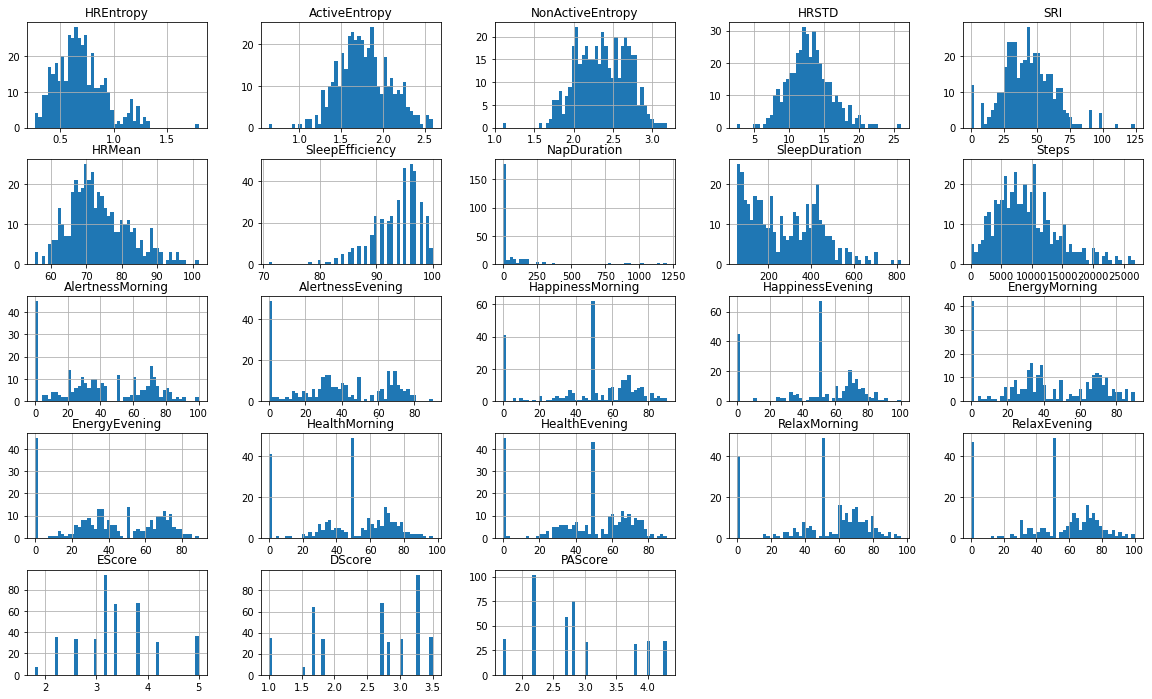

In [71]:
# Look at distributions of features
features2 = ['HREntropy','ActiveEntropy','NonActiveEntropy','HRSTD','SRI','HRMean','SleepEfficiency','NapDuration', 'SleepDuration','Steps', 'AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening','EScore', 'DScore', 'PAScore']
%matplotlib inline
risk_frame.hist(column=features2, bins = 50, figsize=(20,12))

In [72]:
# Empirically test for normal/Gaussian distribution, need to check because it is an assumption of correlation test
norm_feat = []
for f in features2:
    norm = normaltest(risk_frame[f].values,nan_policy='omit')
    if norm[-1] < 0.05:
        print(f + ' is Normal')
        norm_feat.append(f)
    else:
        print(f + ' is not Normal')

HREntropy is Normal
ActiveEntropy is not Normal
NonActiveEntropy is not Normal
HRSTD is Normal
SRI is Normal
HRMean is Normal
SleepEfficiency is Normal
NapDuration is Normal
SleepDuration is Normal
Steps is Normal
AlertnessMorning is Normal
AlertnessEvening is Normal
HappinessMorning is Normal
HappinessEvening is Normal
EnergyMorning is Normal
EnergyEvening is Normal
HealthMorning is Normal
HealthEvening is Normal
RelaxMorning is Normal
RelaxEvening is Normal
EScore is Normal
DScore is Normal
PAScore is Normal


In [75]:
# Create Correlations table
features = ['HREntropy','ActiveEntropy','NonActiveEntropy','HRSTD','SRI','HRMean','SleepEfficiency','NapDuration', 'SleepDuration','Steps', 'AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening']
correlations = pd.DataFrame([[0,0,0,0,0,0]], columns = ['HighRisk Mean', 'LowRisk Mean', 'ANOVA P-Value', 'Pearson Correlation JBS-E', 'Pearson Correlation JBS-D', 'Pearson Correlation JBS-PA'])
# ANOVA test, and correlation tests
for feat in features:
    hr = [x for x in list(highrisk.loc[:, feat].values) if str(x) != 'nan']
    lr = [x for x in list(lowrisk.loc[:, feat].values) if str(x) != 'nan']
    pval = f_oneway(hr,lr)[1]
    # Only perform correlation test on normal distributions
    if feat in norm_feat:
        # Remove NaN
        idx = ~ np.isnan(risk_frame[feat])
        corre, _ = pearsonr(risk_frame[feat][idx], risk_frame['EScore'][idx])
        corrd, _ = pearsonr(risk_frame[feat][idx], risk_frame['DScore'][idx])
        corrpa, _ = pearsonr(risk_frame[feat][idx], risk_frame['PAScore'][idx])
    else:
        corre = corrd = corrpa = None
    pval = round(pval, 4)
    correlations.loc[feat,:] = [mean(hr), mean(lr), pval, corre, corrd, corrpa]
correlations.drop([0], inplace=True)

In [178]:
correlations.sort_values(by='ANOVA P-Value')

,HighRisk Mean,LowRisk Mean,ANOVA P-Value,Pearson Correlation JBS-E,Pearson Correlation JBS-D,Pearson Correlation JBS-PA
NonActiveEntropy,2.338577,2.594218,0.0000,NaN,NaN,NaN
HRMean,74.479398,65.913896,0.0000,0.079901,-0.066777,0.040252
ActiveEntropy,1.796343,1.604832,0.0001,NaN,NaN,NaN
HappinessEvening,49.945946,34.285714,0.0285,-0.090243,-0.069510,0.114922
SRI,43.558257,36.249669,0.0313,0.237713,0.222557,-0.144636
HealthEvening,46.077220,31.571429,0.0353,-0.030683,0.001524,0.047667
RelaxEvening,50.046332,34.357143,0.0355,-0.000276,0.070932,-0.012791
SleepDuration,270.855882,324.500000,0.0473,0.026113,0.140715,-0.096126
Steps,9274.828729,7929.261905,0.1024,0.010878,0.083103,-0.231070
EnergyEvening,41.694981,31.500000,0.1503,-0.040663,0.045185,0.019551


**Categorical variables next**

In [68]:
# Create Correlations table for categorical 
categorical = ['CupsofCaffeine', 'AlcoholicDrinks', 'NumberofNaps', 'HoursWorked', 'WakeMethod(0-2)', 'TimeToFallAsleep(0-5)', 'ShiftType(1-3)']
catcorr = pd.DataFrame([[0,0,0,0,0,0]], columns = ['HighRisk Mean', 'LowRisk Mean', 'Kruksal Wallis P-Value', 'PBS JBS-E', 'PBS JBS-D', 'PBS JBS-PA'])
# ANOVA test, and correlation tests
for feat in categorical:
    risk_frame[feat] = risk_frame[feat].astype('float64')
    hr = [x for x in list(highrisk.loc[:, feat].values) if str(x) != 'nan']
    lr = [x for x in list(lowrisk.loc[:, feat].values) if str(x) != 'nan']
    # Kruskal Wallis, non parametric equivalent to ANOVA
    pval = kruskal(hr,lr, nan_policy='omit')[1]
    # Point biserial for categorical in place of correlation test
    # Remove NaN
    idx = ~ np.isnan(risk_frame[feat])
    corre, _ = pointbiserialr(risk_frame[feat][idx], risk_frame['EScore'][idx])
    corrd, _ = pointbiserialr(risk_frame[feat][idx], risk_frame['DScore'][idx])
    corrpa, _ = pointbiserialr(risk_frame[feat][idx], risk_frame['PAScore'][idx])
    pval = round(pval, 4)
    catcorr.loc[feat,:] = [mean(hr), mean(lr), pval, corre, corrd, corrpa]
catcorr.drop([0], inplace=True)

In [179]:
catcorr.sort_values(by='Kruksal Wallis P-Value')

,HighRisk Mean,LowRisk Mean,Kruksal Wallis P-Value,PBS JBS-E,PBS JBS-D,PBS JBS-PA
WakeMethod(0-2),0.528958,1.000000,0.0278,-0.249465,-0.123806,0.119034
HoursWorked,3.953668,6.285714,0.0339,-0.022155,-0.043914,-0.024291
TimeToFallAsleep(0-5),0.532819,1.000000,0.0763,-0.126426,-0.262921,0.024157
AlcoholicDrinks,0.258687,0.000000,0.0817,0.055668,0.010935,0.099315
CupsofCaffeine,0.876448,1.357143,0.2104,-0.289588,-0.233073,0.244728
NumberofNaps,0.451737,0.285714,0.2500,-0.064509,-0.069154,0.134879
ShiftType(1-3),1.960938,2.181818,0.3825,0.052709,-0.077691,-0.085622


## Calculate Previous Days Mean and STD for 3,5, and 7 days
**Perform on Time Series Data**

In [81]:
# Make sure index is in chronological order
feature_table = feature_table.reset_index(drop=True)

In [174]:
# Function that returns mean and standard deviation of previous intervals of time for a given feature
def previous_mean_std(feat):
    idx = 0
    
    # Initialize mean arrays and standard deviation arrays
    corr3 = np.zeros(feature_table.shape[0])
    corr5 = np.zeros(feature_table.shape[0])
    corr7 = np.zeros(feature_table.shape[0])

    stdcorr3 = np.zeros(feature_table.shape[0])
    stdcorr5 = np.zeros(feature_table.shape[0])
    stdcorr7 = np.zeros(feature_table.shape[0])


    for user in list(feature_table.User.unique()):
        user_frame = feature_table.loc[feature_table['User'] == user, ['Date', feat]].sort_values(by='Date')
        date_end = datetime.datetime.strptime(user_frame.Date.values[-1], '%Y-%m-%d')
        date_start = datetime.datetime.strptime(user_frame.Date.values[0], '%Y-%m-%d')
        dur = (date_end-date_start).days + 1
        
        feature_series = []
        for i in range(dur):
            curr_date = (date_start + datetime.timedelta(days=i)).strftime('%Y-%m-%d')
            if (curr_date in user_frame.Date.values) and (list(user_frame.loc[user_frame['Date']==curr_date, feat].unique())[0] != None):
                idx += 1
                feature_series.append(float(list(user_frame.loc[user_frame['Date']==curr_date, feat].unique())[0]))
                if i > 1:
                    three = [x for x in feature_series[(i-2):(i+1)] if np.isnan(x) == False]
                    if len(three) == 0:
                        corr3[idx] = np.float('nan')
                        stdcorr3[idx] = np.float('nan')
                    else:
                        corr3[idx] = mean(three)
                        stdcorr3[idx] = pstdev(three)
                if i > 3:
                    five = [x for x in feature_series[(i-4):(i+1)] if np.isnan(x) == False]
                    if len(five) == 0:
                        corr5[idx] = np.float('nan')
                        stdcorr5[idx] = np.float('nan')
                    else:
                        corr5[idx] = mean(five)
                        stdcorr5[idx] = pstdev(five)
                if i > 5:
                    seven = [x for x in feature_series[(i-6):(i+1)] if np.isnan(x) == False]
                    if len(seven) == 0:
                        corr7[idx] = np.float('nan')
                        stdcorr7[idx] = np.float('nan')
                    else:
                        corr7[idx] = mean(seven)
                        stdcorr7[idx] = pstdev(seven)
            else:
                feature_series.append(np.float('nan'))

    return np.array([corr3, corr5, corr7, stdcorr3, stdcorr5, stdcorr7])

In [175]:
avg = previous_mean_std('Steps')
avg_transpose = np.transpose(avg)
feature_table.loc[:, ['3DayAverageSteps', '5DayAverageSteps', '7DayAverageSteps', '3DaySTDSteps', '5DaySTDSteps', '7DaySTDSteps']] = avg_transpose

avg = previous_mean_std('HRMean')
avg_transpose = np.transpose(avg)
feature_table.loc[:, ['3DayAverageHRMean', '5DayAverageHRMean', '7DayAverageHRMean', '3DaySTDHRMean', '5DaySTDHRMean', '7DaySTDHRMean']] = avg_transpose

avg = previous_mean_std('HRSTD')
avg_transpose = np.transpose(avg)
feature_table.loc[:, ['3DayAverageHRSTD', '5DayAverageHRSTD', '7DayAverageHRSTD', '3DaySTDHRSTD', '5DaySTDHRSTD', '7DaySTDHRSTD']] = avg_transpose

avg = previous_mean_std('SleepEfficiency')
avg_transpose = np.transpose(avg)
feature_table.loc[:, ['3DayAverageSleepEfficiency', '5DayAverageSleepEfficiency', '7DayAverageSleepEfficiency', '3DaySTDSleepEfficiency', '5DaySTDSleepEfficiency', '7DaySTDSleepEfficiency']] = avg_transpose

avg = previous_mean_std('SleepDuration')
avg_transpose = np.transpose(avg)
feature_table.loc[:, ['3DayAverageSleepDuration', '5DayAverageSleepDuration', '7DayAverageSleepDuration', '3DaySTDSleepDuration', '5DaySTDSleepDuration', '7DaySTDSleepDuration']] = avg_transpose

In [177]:
feature_table.head(20)

,User,Date,CupsofCaffeine,AlcoholicDrinks,WakeMethod(0-2),TimeToFallAsleep(0-5),HoursWorked,OverTime(Mins),NoSleep,ShiftType(1-3),...,7DayAverageSleepEfficiency,3DaySTDSleepEfficiency,5DaySTDSleepEfficiency,7DaySTDSleepEfficiency,3DayAverageSleepDuration,5DayAverageSleepDuration,7DayAverageSleepDuration,3DaySTDSleepDuration,5DaySTDSleepDuration,7DaySTDSleepDuration
0,1001,2020-12-01,3.0,0.0,2.0,0.0,0.0,0.0,1.0,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1001,2020-12-11,3.0,0.0,2.0,0.0,0.0,0.0,1.0,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1001,2020-12-12,3.0,0.0,2.0,0.0,0.0,0.0,1.0,NaN,...,85.000000,0.000000,0.000000,0.000000,78.000000,78.000000,78.000000,0.000000,0.000000,0.000000
3,1001,2020-12-13,3.0,0.0,2.0,0.0,0.0,0.0,1.0,NaN,...,89.500000,4.500000,4.500000,4.500000,81.000000,81.000000,81.000000,3.000000,3.000000,3.000000
4,1001,2020-12-14,3.0,0.0,2.0,0.0,0.0,0.0,1.0,NaN,...,92.333333,5.436502,5.436502,5.436502,139.333333,139.333333,139.333333,82.532149,82.532149,82.532149
5,1001,2020-12-15,3.0,0.0,2.0,0.0,0.0,0.0,1.0,NaN,...,93.500000,1.699673,5.123475,5.123475,220.666667,185.000000,185.000000,100.323920,106.606754,106.606754
6,1001,2020-12-16,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,...,94.600000,0.816497,5.083306,5.083306,311.333333,219.200000,219.200000,41.515727,117.348029,117.348029
7,1001,2020-12-17,3.0,0.0,2.0,0.0,0.0,0.0,1.0,NaN,...,95.000000,0.942809,1.673320,4.725816,335.666667,269.400000,237.500000,14.659089,98.357714,114.673086
8,1001,2020-12-18,3.0,0.0,2.0,0.0,0.0,0.0,1.0,NaN,...,95.428571,0.816497,0.748331,4.499433,371.000000,338.200000,264.714286,41.785165,55.650337,125.359727
9,1001,2020-12-19,3.0,0.0,2.0,0.0,0.0,0.0,1.0,NaN,...,97.166667,0.500000,0.829156,1.572330,378.500000,358.750000,295.833333,49.500000,41.948629,107.496382


In [180]:
feature_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763 entries, 0 to 762
Data columns (total 64 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User                        763 non-null    object 
 1   Date                        763 non-null    object 
 2   CupsofCaffeine              512 non-null    float64
 3   AlcoholicDrinks             511 non-null    float64
 4   WakeMethod(0-2)             512 non-null    float64
 5   TimeToFallAsleep(0-5)       511 non-null    float64
 6   HoursWorked                 512 non-null    float64
 7   OverTime(Mins)              512 non-null    float64
 8   NoSleep                     505 non-null    float64
 9   ShiftType(1-3)              276 non-null    float64
 10  AlertnessMorning            512 non-null    float64
 11  AlertnessEvening            510 non-null    float64
 12  HappinessMorning            512 non-null    float64
 13  HappinessEvening            512 non